# Project 1 - Data Engineering
## 2 Data Exploration and Analysis

**Here**: Jupyter Notebook for Writing the Code, VS Code for version control

### Health DG 
## 99. Alzheimer's Disease and Healthy Aging Data


## E1 - Obtain and Scrub

In [1]:
# Load necessary packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
import numpy as np
from scipy import stats
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import geopandas as gpd
import zipfile
import matplotlib.patches as patches
from shapely import wkt


In [2]:
# Set display options to better analize the dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Load dataset
zf = zipfile.ZipFile('Alzheimer_s_Disease_and_Healthy_Aging_Data.zip') 
df = pd.read_csv(zf.open('Alzheimer_s_Disease_and_Healthy_Aging_Data.csv'))

In [3]:
# Check Shape and Dtypes before cleanup
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250937 entries, 0 to 250936
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RowId                       250937 non-null  object 
 1   YearStart                   250937 non-null  int64  
 2   YearEnd                     250937 non-null  int64  
 3   LocationAbbr                250937 non-null  object 
 4   LocationDesc                250937 non-null  object 
 5   Datasource                  250937 non-null  object 
 6   Class                       250937 non-null  object 
 7   Topic                       250937 non-null  object 
 8   Question                    250937 non-null  object 
 9   Response                    0 non-null       float64
 10  Data_Value_Unit             250937 non-null  object 
 11  DataValueTypeID             250937 non-null  object 
 12  Data_Value_Type             250937 non-null  object 
 13  Data_Value    

(250937, 39)

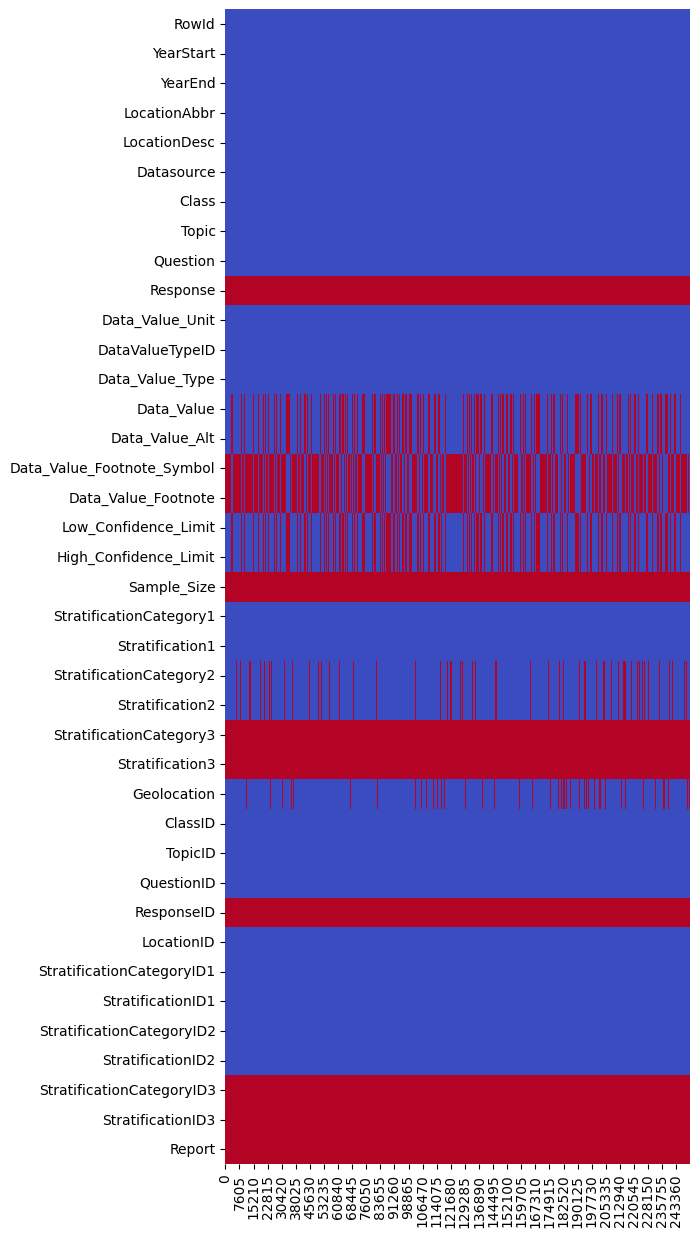

In [4]:
# Visualize missing values in heatmap
plt.figure(figsize=(6, 15))
sns.heatmap(df.T.isnull(), cbar=False, cmap='coolwarm')
plt.show()

In [5]:
# data.select_dtypes(include=['float64', 'int64']).columns
df['Datasource'].unique()

array(['BRFSS'], dtype=object)

In [6]:
##############################
##### Cleaning the data ######
##############################

# Droping columns where all rows have the value null
columns_to_drop = [ 
            'Datasource', # Droping because all rows have the same value (BRFSS)
            'Response', 
            'Sample_Size', 
            'StratificationCategory3', 
            'Stratification3',
            'ResponseID',
            'StratificationCategoryID3',
            'StratificationID3',
            'Report',
            'Data_Value_Footnote_Symbol',
            'Data_Value_Footnote' #,
            # 'Geolocation'
        ]

df_cleaned = df.drop(columns=columns_to_drop)

# Converting 'Low_Confidence_Limit' and 'High_Confidence_Limit' to numeric (if possible)
df_cleaned['Low_Confidence_Limit'] = pd.to_numeric(df_cleaned['Low_Confidence_Limit'], errors='coerce').astype(float)
df_cleaned['High_Confidence_Limit'] = pd.to_numeric(df_cleaned['High_Confidence_Limit'], errors='coerce').astype(float)

# Convert rest of the columns to type sting 
string_cols = df_cleaned.select_dtypes(include=['object']).columns
for col in string_cols:
    df_cleaned[col] = df_cleaned[col].astype('string').str.strip()

# Sort the df by StartYear
df_cleaned = df_cleaned.sort_values(by='YearStart')

# Drop Geolocation as it's no longer needed

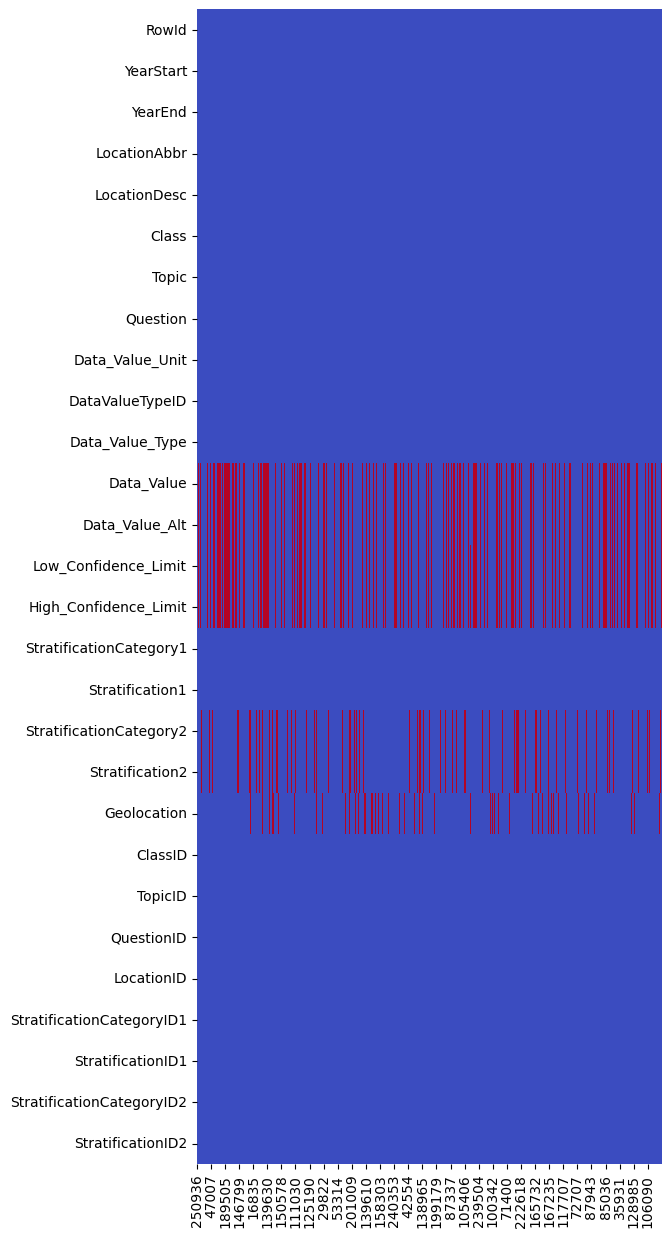

In [7]:
# Check heatmap after cleanup
plt.figure(figsize=(6, 15))
sns.heatmap(df_cleaned.T.isnull(), cbar=False, cmap='coolwarm')
plt.show()

In [8]:
# Check Shape and Dtypes after cleanup
df_cleaned.info()
df_cleaned.shape
# result: Dtypes are correctly set and 10 columns have been droped

<class 'pandas.core.frame.DataFrame'>
Index: 250937 entries, 250936 to 125468
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RowId                      250937 non-null  string 
 1   YearStart                  250937 non-null  int64  
 2   YearEnd                    250937 non-null  int64  
 3   LocationAbbr               250937 non-null  string 
 4   LocationDesc               250937 non-null  string 
 5   Class                      250937 non-null  string 
 6   Topic                      250937 non-null  string 
 7   Question                   250937 non-null  string 
 8   Data_Value_Unit            250937 non-null  string 
 9   DataValueTypeID            250937 non-null  string 
 10  Data_Value_Type            250937 non-null  string 
 11  Data_Value                 169302 non-null  float64
 12  Data_Value_Alt             169302 non-null  float64
 13  Low_Confidence_Limit       16

(250937, 28)

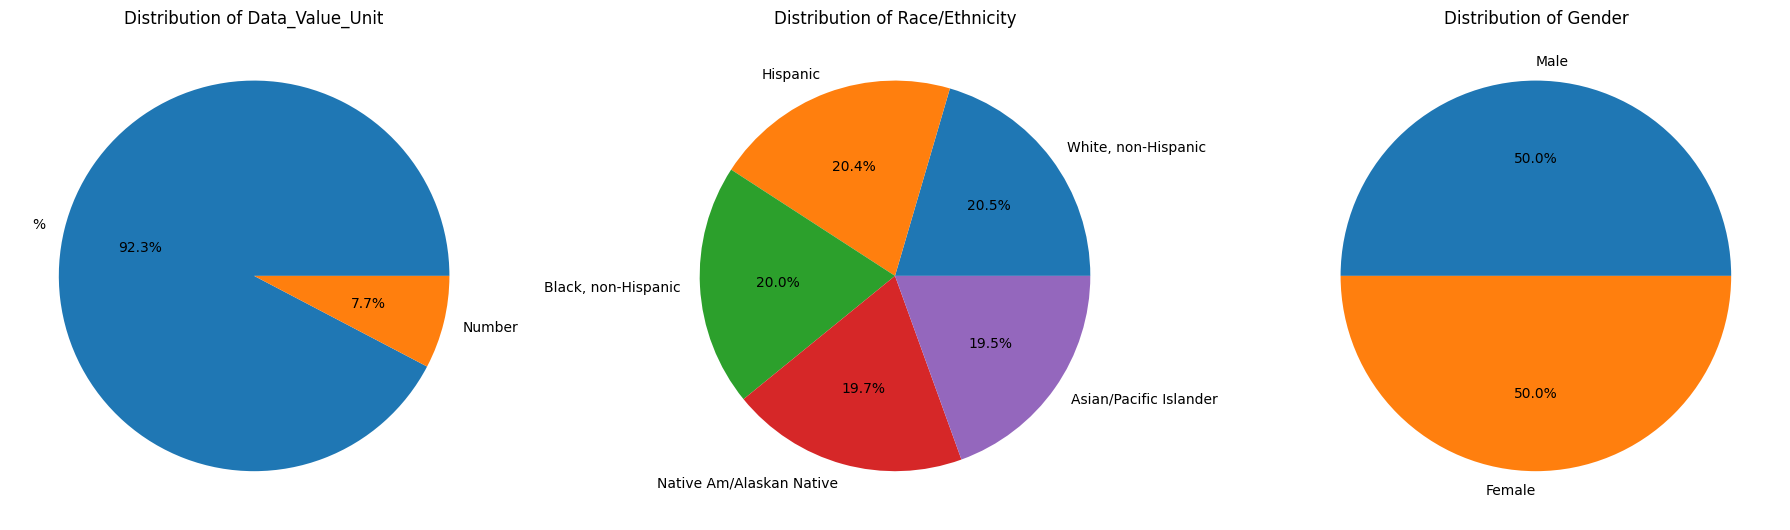

In [9]:
# Plot 1: Pie plots devided into Data_Value_Unit, Stratification2 (Ethnicity/Race),  Stratification2 (Gender) 

# Calculate value counts
value_counts_data_unit = df_cleaned['Data_Value_Unit'].value_counts()
value_counts_race_ethnicity = df_cleaned[df_cleaned['StratificationCategory2'] == 'Race/Ethnicity']['Stratification2'].value_counts()
value_counts_gender = df_cleaned[df_cleaned['StratificationCategory2'] == 'Gender']['Stratification2'].value_counts()

# Set up a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot 1: Pie chart for Data_Value_Unit
axes[0].pie(value_counts_data_unit, labels=value_counts_data_unit.index, autopct='%1.1f%%')
axes[0].set_title('Distribution of Data_Value_Unit')

# Plot 2: Pie chart for Race/Ethnicity
axes[1].pie(value_counts_race_ethnicity, labels=value_counts_race_ethnicity.index, autopct='%1.1f%%')
axes[1].set_title('Distribution of Race/Ethnicity')

# Plot 3: Pie chart for Gender
axes[2].pie(value_counts_gender, labels=value_counts_gender.index, autopct='%1.1f%%')
axes[2].set_title('Distribution of Gender')

# Show the plots
plt.tight_layout()
plt.show()

In [10]:
# Since the data is devided into two data_value_types:

##### Spliting df for further analysis ######
df_cleaned_value_type_percent = df_cleaned[df_cleaned['Data_Value_Unit'] == '%']
df_cleaned_value_type_number = df_cleaned[df_cleaned['Data_Value_Unit'] == 'Number']

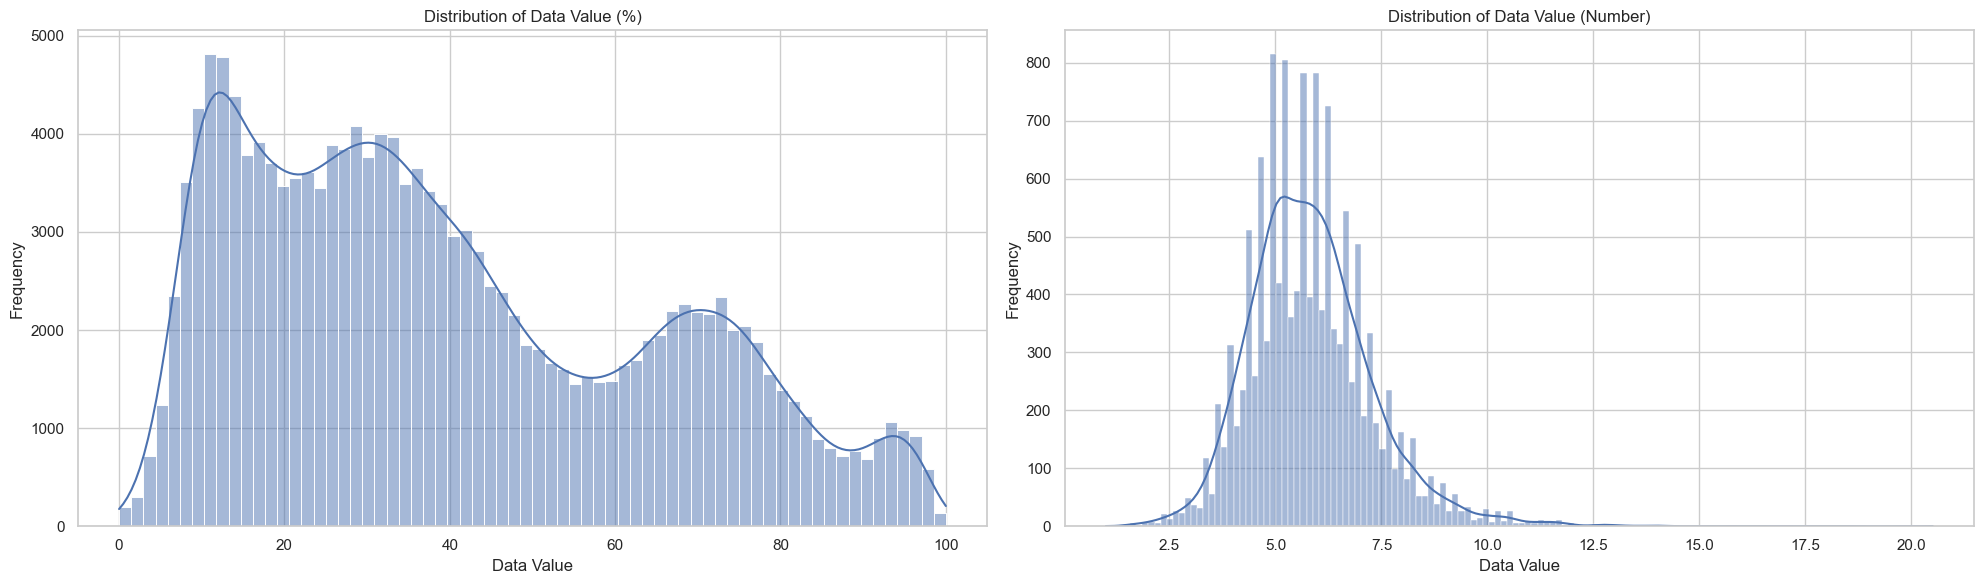

In [11]:
# Statustical Numerical description
df_subset = df_cleaned.sample(n=10000, random_state=1)

sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot 1: Distribution of 'Data_Value' where 'Data_Value_Unit' == '%'
sns.histplot(df_cleaned_value_type_percent['Data_Value'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Data Value (%)')
axes[0].set_xlabel('Data Value')
axes[0].set_ylabel('Frequency')

# Plot 2: Distribution of 'Data_Value' where 'Data_Value_Unit' == 'Number'
sns.histplot(df_cleaned_value_type_number['Data_Value'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Data Value (Number)')
axes[1].set_xlabel('Data Value')
axes[1].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

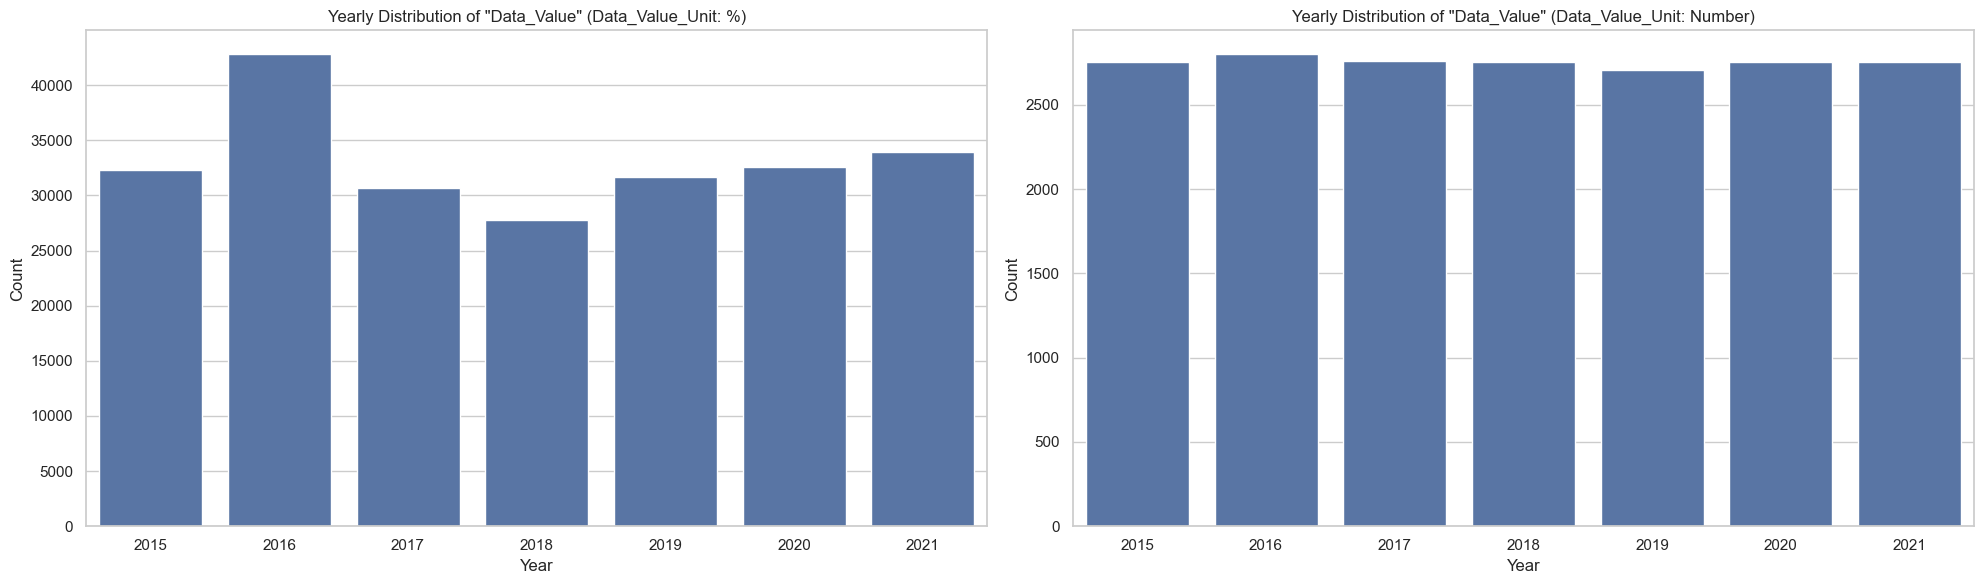

In [12]:
# Plot 2: Yearly Distribution
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot 1: Yearly Distribution for all data
sns.countplot(x='YearStart', data=df_cleaned[df_cleaned['Data_Value_Unit'] == '%'], color='#4c72b0', ax=axes[0])
axes[0].set_title('Yearly Distribution of "Data_Value" (Data_Value_Unit: %)')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Count')

# Plot 2: Yearly Distribution for 'Data_Value_Unit' == 'Number'
sns.countplot(x='YearStart', data=df_cleaned[df_cleaned['Data_Value_Unit'] == 'Number'], color='#4c72b0', ax=axes[1])
axes[1].set_title('Yearly Distribution of "Data_Value" (Data_Value_Unit: Number)')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()

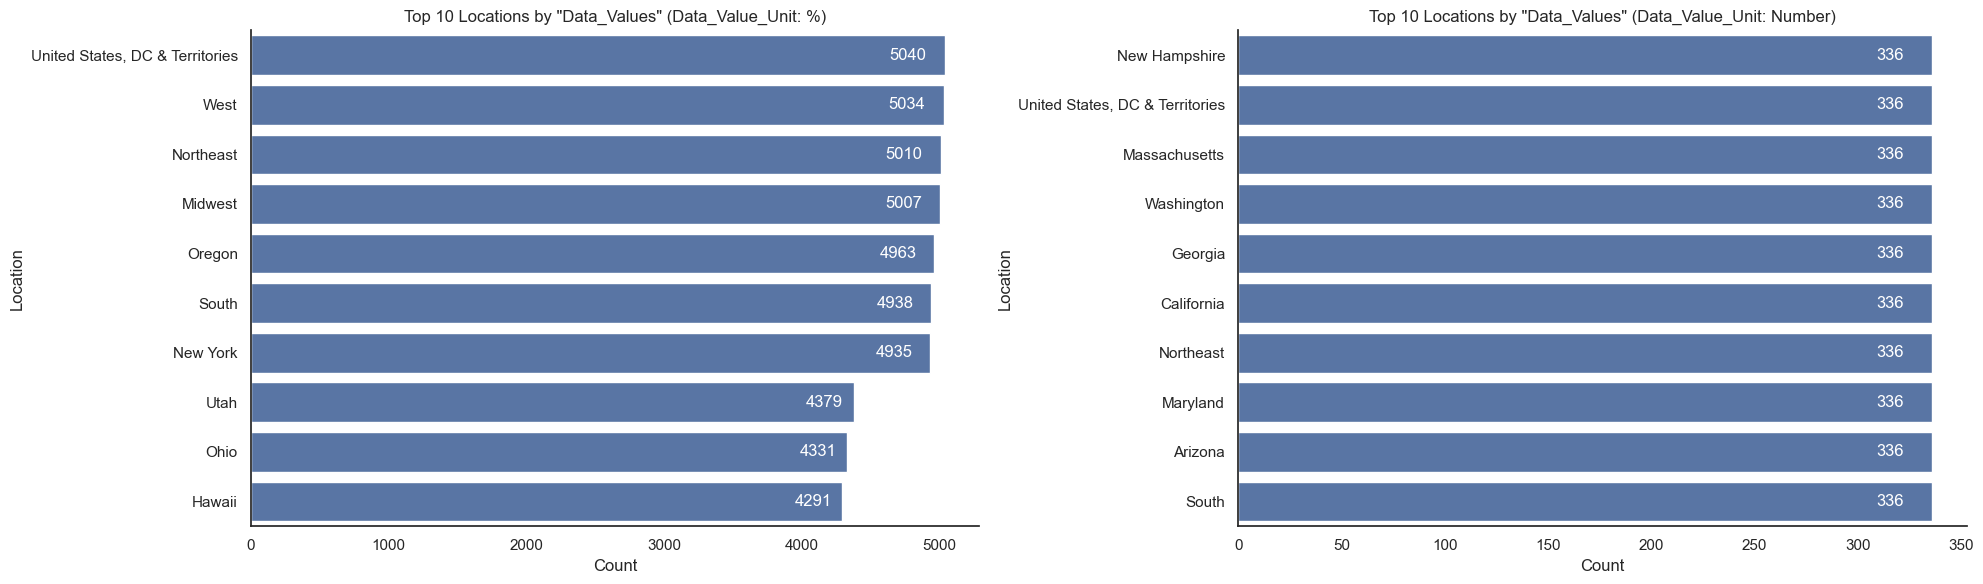

In [65]:
# # Plot 3: Top 10 Locations by Data Count
# Top 10 Locations for Data_Value_Unit == '%' and Data_Value_Unit == 'Number'
top_locations_percent = df_cleaned_value_type_percent['LocationDesc'].value_counts().head(10).sort_values(ascending=False)
top_locations_number = df_cleaned_value_type_number['LocationDesc'].value_counts().head(10).sort_values(ascending=False)

sns.set(style="white")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Remove top and right borders from plots
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Plot 1: Top 10 Locations (Data_Value_Unit: %)
sns.barplot(x=top_locations_percent.values, y=top_locations_percent.index, color='#4c72b0', ax=axes[0])
axes[0].set_title('Top 10 Locations by "Data_Values" (Data_Value_Unit: %)')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Location')

# Add text labels for Plot 1
for b in axes[0].patches:
    width = b.get_width()
    axes[0].text(width - (width*0.08), b.get_y() + b.get_height() / 2, int(width), ha='left', va='center', color = 'white')

# Plot 2: Top 10 Locations (Data_Value_Unit: Number)
sns.barplot(x=top_locations_number.values, y=top_locations_number.index, color='#4c72b0', ax=axes[1])
axes[1].set_title('Top 10 Locations by "Data_Values" (Data_Value_Unit: Number)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Location')

# Add text labels for Plot 2
for b in axes[1].patches:
    width = b.get_width()
    axes[1].text(width - (width*0.08), b.get_y() + b.get_height() / 2, int(width), ha='left', va='center', color = 'white')

# Display the plots
plt.tight_layout()
plt.show()

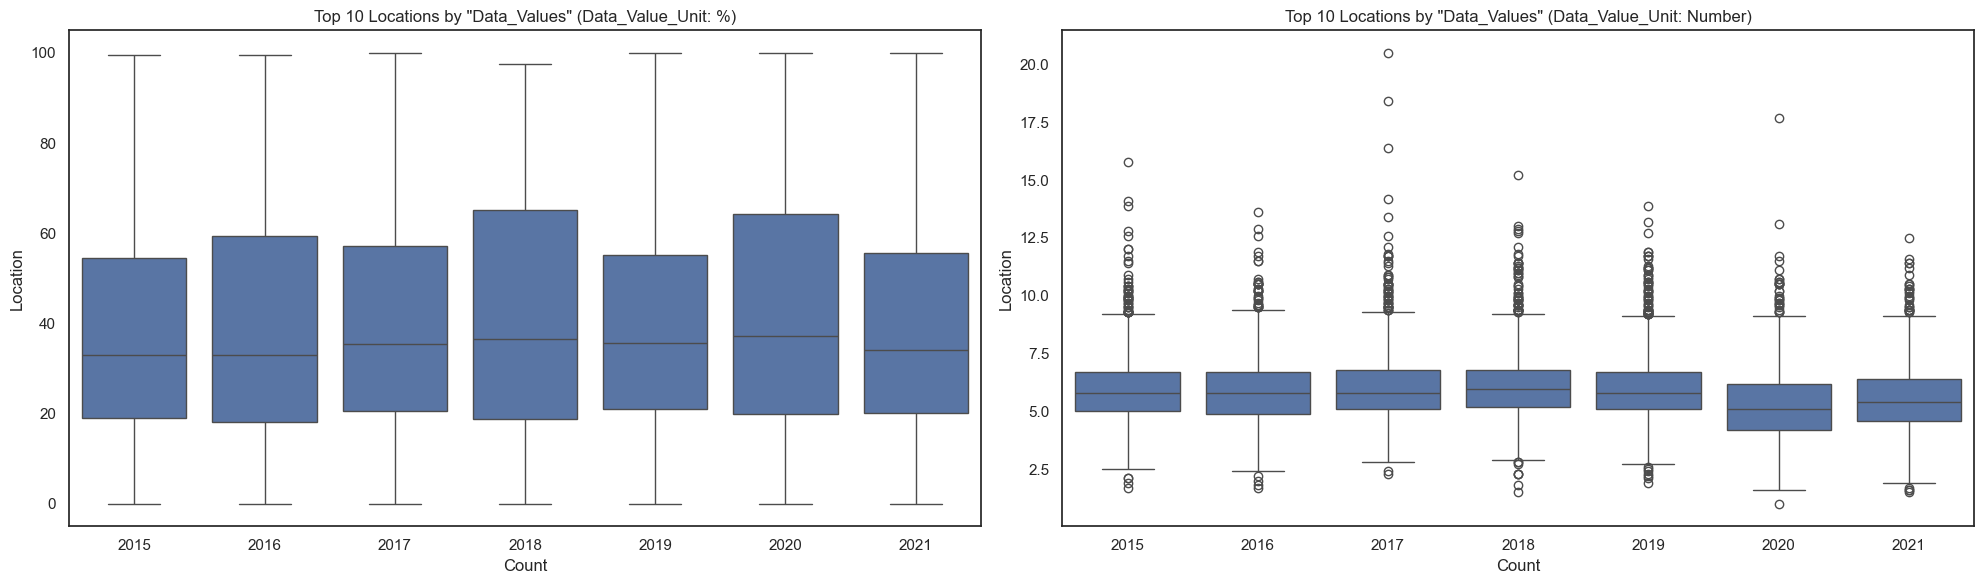

In [14]:
# Plot 4: Boxplot of Data Value by Year
sns.set(style="white")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot 1: Boxplot of Data_Values (Data_Value_Unit: %)
sns.boxplot(x='YearStart', y='Data_Value', data=df_cleaned_value_type_percent, color='#4c72b0', ax=axes[0])
axes[0].set_title('Top 10 Locations by "Data_Values" (Data_Value_Unit: %)')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Location')

# Plot 2: Boxplot of Data_Values (Data_Value_Unit: Number)
sns.boxplot(x='YearStart', y='Data_Value', data=df_cleaned_value_type_number, color='#4c72b0', ax=axes[1])
axes[1].set_title('Top 10 Locations by "Data_Values" (Data_Value_Unit: Number)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Location')

# Display the plots
plt.tight_layout()
plt.show()

In [15]:
# Rows where Latitude and Longitude are null are territory data see:
territories = df_cleaned[df_cleaned['Geolocation'].isna()]['LocationDesc'].unique()
territories

<StringArray>
['Midwest', 'United States, DC & Territories', 'South', 'West', 'Northeast']
Length: 5, dtype: string

In [16]:
# The dataframe contains different locations. Some of them are the 50 United states of America, others the territories of the USA
# and there are aslo four special jurisdiction territories which have to be split in order to avoid misleading data  

##### Spliting dataframe ######
special_jurisdictions = ['District of Columbia', 'Guam', 'Puerto Rico', 'Virgin Islands']

df_special_jurisdictions = df_cleaned[df_cleaned['LocationDesc'].isin(special_jurisdictions)] # special jurisdictions see above
df_territories = df_cleaned[df_cleaned['LocationDesc'].isin(territories)] # us territories like: West, East, etc.
df_states = df_cleaned[~df_cleaned['LocationDesc'].isin(special_jurisdictions) & ~df_cleaned['LocationDesc'].isin(territories)] # USA's 50 states


## E2 - Exploratory data analysis (EDA)

# Textual description of Fields
The cleaned dataset consists of 29 columns which contain information on various surveys regarding public health in the US.
of these, 20 are categorical and 9 are numeric. Specifically, 3 of the numeric variables are integers.
These are the most important fields in the dataset, in order of appearance in the data, as well as their data type:
 - *RowId* (string): A unique Identifier for each column. The ID contains information on some of the columns in the Row. Explicitly, it is formatted like this: *Datasource*\~*YearStart*\~*YearEnd*\~*LocationID*\~*QuestionID*\~*TopicID*\~*StratificationCategoryID1*\~*StratificationCategoryID2*.
 - *YearStart* and *YearEnd* (integers): Years when the survey started and ended, respectively.
 - *LocationAbbr* (string): an Abbreviation of the Location where the survey took place. for single states, it is the ISO-Code of the state, for regions an abbreviated form of the area (for example "NRE" for "Northeast").
 - *LocationDesc* (string): Full name of the state or region where the survey took place.
 - *Class* (string): Focus of the specific survey, eg. "Overall Health" or "Screenings and Vaccines".
 - *Topic* (string): A short description of the Topic of the survey.
 - *Question* (string): Question asked in the survey.
 - *Data_Value_Type* (string): Type of the *Data_Value*, e.g. "Mean" or "Percentage".
 - *Data_Value* (float): The actual Value of the survey result.
 - *Low_Confidence_Limit* and *High_Confidence_Limit* (floats): the lower and upper bounds of the confidence interval, respectively.
 - *StratificationCategory1* and *StratificationCategory2* (strings): Categories by which the target population of the survey is selected
 - *Stratification1* and *Stratification2* (strings): Specific stratification groups selected for the survey
 - *Latitude* and *Longitude* (floats): Coordinates of the survey

in Addition, there are *\~ID* columns which abbreviate the values into identifiers for the following columns: *Data_Value_Type*, *Class*, *Topic*, *Question*, *Location*, *StratificationCategory1*, *Stratification1*, *StratificationCategory2* and *Stratification2*





In [17]:
# Filter df for sunburst plot
df_cleaned_filtered = df_cleaned[
  (df_cleaned['Data_Value_Unit'] == '%') & 
  (df_cleaned['Stratification1'] == 'Overall') &
  (df_cleaned['LocationAbbr'] == 'US') &
  (df_cleaned['StratificationCategory2'] == 'Gender')
  ].sort_values(by='Topic')

fig = px.sunburst(df_cleaned_filtered, 
                  path=['Stratification2', 'Topic'],  
                  values='Data_Value',  
                  color='Data_Value', 
                  hover_name='Topic', 
                  title='Sunburst chart for topics by gender in whole of the US', 
                  color_continuous_scale=px.colors.sequential.RdBu_r,
                  height=800,
                  width=1000)

fig.show()

In [18]:
# Filter the data for 'Female'
df_female = df_cleaned_filtered[df_cleaned_filtered['Stratification2'] == 'Female'].sort_values(by='Topic')

# Create histogram for 'Female'
fig_female = px.histogram(df_female, x='Data_Value', color='Topic',
                          labels={'Data_Value': 'Data Value (%)'},
                          title='Histogram of Topics for Female',
                          marginal='rug')
fig_female.update_layout(legend=dict(font=dict(size=10)))

# Filter the data for 'Male'
df_male = df_cleaned_filtered[df_cleaned_filtered['Stratification2'] == 'Male'].sort_values(by='Topic')

# Create histogram for 'Male'
fig_male = px.histogram(df_male, x='Data_Value', color='Topic',
                        labels={'Data_Value': 'Data Value (%)'},
                        title='Histogram of Topics for Male',
                        marginal='rug')
fig_male.update_layout(legend=dict(font=dict(size=10)))

# Show the figures
fig_female.show()
fig_male.show()

In [19]:
# Group by 'YearStart' and 'Topic', then calculate the mean of 'Data_Value'
avg_data = df_cleaned_filtered.groupby(['YearStart', 'Topic'])['Data_Value'].mean().reset_index()

# Create an interactive line plot
fig = px.line(avg_data, x='YearStart', y='Data_Value', color='Topic',
              labels={'Data_Value': 'Average Data Value (%)', 'YearStart': 'Year'},
              title='Trend in Data Value by Topic')

fig.update_layout(
  height=920
)

fig.show()

In [20]:
df_cleaned_filtered = df_cleaned[
  (df_cleaned['Data_Value_Unit'] == '%') & 
  (df_cleaned['Stratification1'] == 'Overall') &
  (df_cleaned['LocationAbbr'] == 'US') &
  (df_cleaned['StratificationCategory2'] == 'Race/Ethnicity')
  ] 

# Creating a horizontal boxplot
fig = px.box(df_cleaned_filtered, y='Stratification2', x='Data_Value', 
             color='Stratification2',  # This adds different colors for each ethnicity/race
             hover_data=['Topic'],  # This sets the hover name to 'Topic'
             orientation='h',  # This makes the boxplot horizontal
             title='Horizontal Boxplot of Data Value by Race/Ethnicity',
             points='all'
             )

# Show the figure
fig.show()

In [21]:
# Load the geopandas shape file
gdf = gpd.read_file('geopandas/cb_2018_us_state_500k.shp')

In [22]:
# Calculate the mean of Data_value
df_states_mean = df_states[df_states['Data_Value_Unit'] == '%'].groupby('LocationDesc')['Data_Value'].mean().reset_index()
# Merge the gdf with the mean values
df_states_gdf = gdf.merge(df_states_mean, left_on='NAME', right_on='LocationDesc')

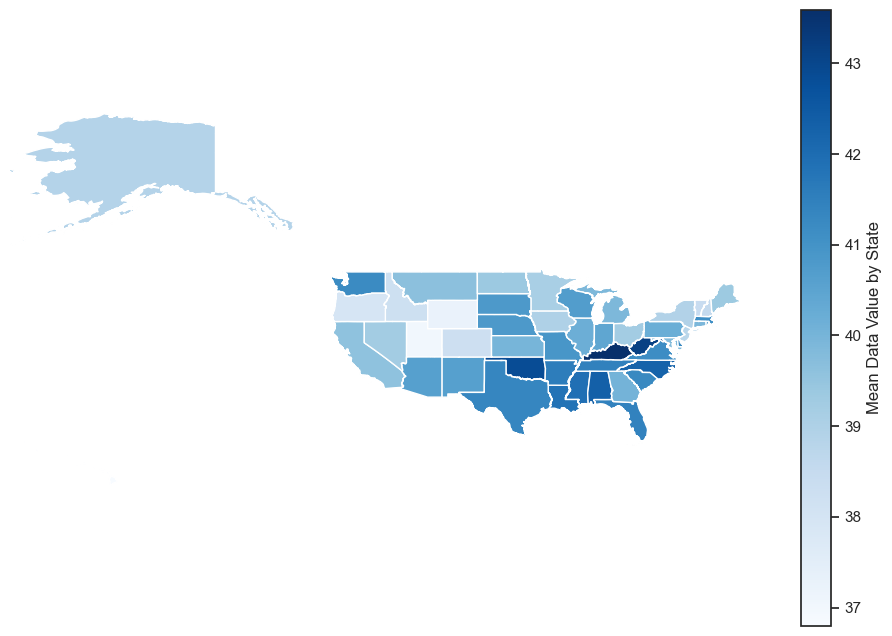

In [23]:
# df_mean_values
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
df_states_gdf.plot(column='Data_Value', ax=ax, legend=True,
                legend_kwds={
                  'label': "Mean Data Value by State",
                  'orientation': "vertical"
                  },
                cmap='Blues'  
              )


# Setting the x and y limits to the continental US bounds
# These bounds are just examples, you will need to adjust them to your specific shapefile
x_bound = (-170, -65)
y_bound = (40, 45)
ax.set_xlim(*x_bound)
ax.set_ylim(*y_bound)

# Set the aspect to equal. This is important for map projections to avoid distortion
ax.set_aspect('equal', adjustable='datalim')
ax.set_axis_off()

plt.show()

### E3-H1: "Males or females with a diagnosis of depression are more prone to be currently smoking"
Author: Tom Perkovic



First the data needs to be narrowed down to the needed observations.
For the above case the percentage data for genders of the topics "Lifetime diagnosis of depression" and "Current smoking".

In [24]:
# Filtering for the needed data
df_a_b = df_states[
  (df_states['Data_Value_Unit'] == '%') & 
  (df_states['StratificationCategoryID2'] == 'GENDER')
  ] 

# Creating two dataframes for the two analysed topics
depression = df_a_b[(df_a_b['Topic'] == 'Lifetime diagnosis of depression')]
smoking = df_a_b[(df_a_b['Topic'] == 'Current smoking')]

To get a quick overview, descriptive statistics per gender are shown.

In [25]:
depression.groupby('Stratification2')['Data_Value'].describe()

count       mean       std  min   25%   50%   75%   max
Stratification2                                                          
Female           1044.0  22.162261  5.442790  8.5  18.1  21.7  25.9  39.3
Male             1043.0  13.215244  3.150753  5.9  11.0  12.9  15.2  26.3

In [26]:
smoking.groupby('Stratification2')['Data_Value'].describe()

count       mean       std  min     25%    50%   75%   max
Stratification2                                                             
Female           1044.0  13.170019  4.912782  2.4   9.175  12.65  16.4  29.6
Male             1044.0  15.059291  5.143412  3.8  11.000  14.60  18.6  31.7

Two histograms, for the analysed topics, split by gender are created, to visualize the distribution of the percentages and their frequency.
Both distributions seem similar to a higher and flatter normal distribution for the depression data.
For the smoking data the peak is more to the left of the distrubution.

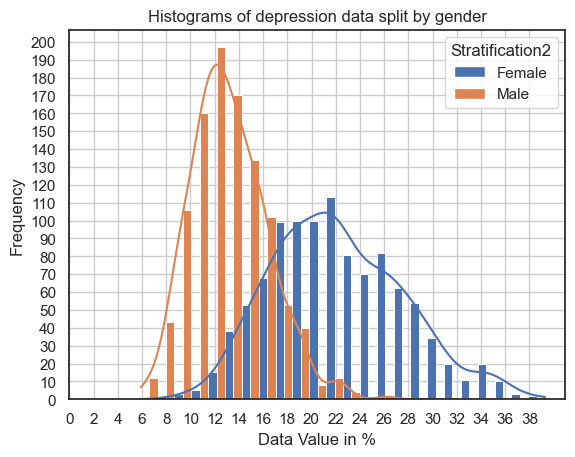

In [27]:
# Plotting a histogram of depression data, split by gender, with a kernel density estimate and the two gender dodging, for better visibility
sns.histplot(
    data = depression,
    x = 'Data_Value',
    hue = 'Stratification2',
    kde = True,
    alpha = 1,
    multiple = 'dodge'
)

# Adding labels to the axes
plt.xlabel('Data Value in %')
plt.ylabel('Frequency')
# Adapting the axes ticks according to the data and adding a grid for better visibility
plt.xticks(range(0, 40, 2))
plt.yticks(range(0, 210, 10))
plt.grid()

# Setting the title of the plot
plt.title('Histograms of depression data split by gender')
plt.show()

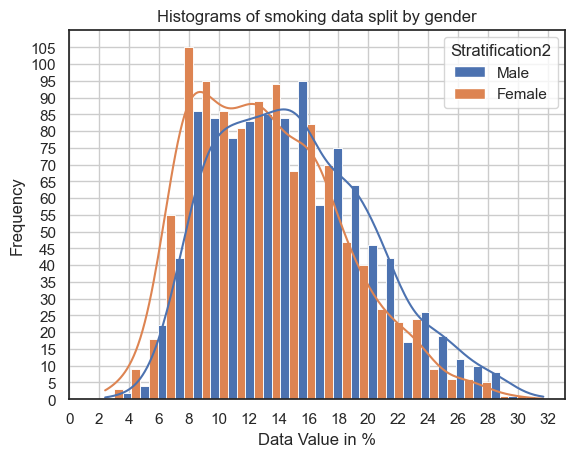

In [28]:
# Plotting a histogram of smoking data, split by gender, with a kernel density estimate and the two gender dodging, for better visibility
sns.histplot(
    data = smoking,
    x = 'Data_Value',
    hue = 'Stratification2',
    kde = True,
    alpha = 1,
    multiple = 'dodge'
)

# Adding labels to the axes
plt.xlabel('Data Value in %')
plt.ylabel('Frequency')

# Adapting the axes ticks according to the data and adding a grid for better visibility
plt.xticks(range(0, 34, 2))
plt.yticks(range(0, 110, 5))
plt.grid()

# Setting the title of the plot
plt.title('Histograms of smoking data split by gender')
plt.show()

The mean percentage per state and gender is calculated and stored in a new dataframe, as shown below.
This will be used to visualize and calculate the correlation of the two topics.

In [29]:
# Grouping the two dataframes by state and gender and then calculating their mean values for correlation 
avg_depression = depression.groupby(['LocationAbbr', 'Stratification2'])['Data_Value'].mean()
avg_smoking = smoking.groupby(['LocationAbbr', 'Stratification2'])['Data_Value'].mean()

# Creating and showing a new dataframe from the two average dataframes created above
avg = pd.DataFrame({'Average Depression': avg_depression, 'Average Smoking': avg_smoking})
avg.head(10)

Average Depression  Average Smoking
LocationAbbr Stratification2                                     
AK           Female                    20.314286        14.433333
             Male                      10.742857        16.457143
AL           Female                    27.619048        15.076190
             Male                      16.180952        18.138095
AR           Female                    26.080952        17.109524
             Male                      16.466667        19.085714
AZ           Female                    21.452381        11.980952
             Male                      12.314286        14.238095
CA           Female                    19.080952         7.500000
             Male                      11.114286        10.847619

The regression plot shows a medium level of correlation for depression and smoking for females, which is backed up by the correlation coefficient.
The p-value indicates that the hypotheses is correct, as it is way below the significance level of 0.025.

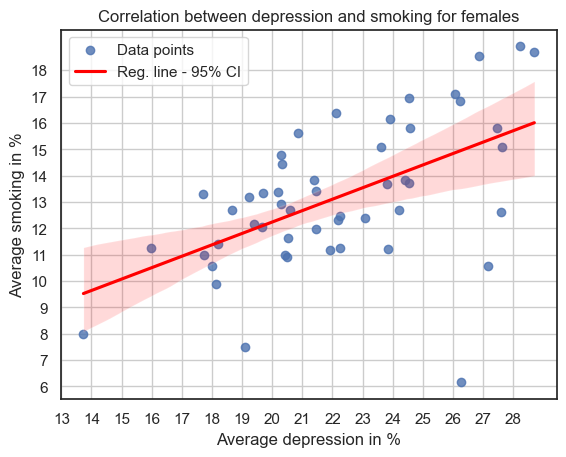

In [30]:
# Creating a regression plot of depression and smoking data for females, with a fitted regression line
sns.regplot(
    data = avg[(avg.index.get_level_values('Stratification2') == 'Female')],
    x = 'Average Depression',
    y = 'Average Smoking',
    ci = 95,
    fit_reg = True,
    line_kws = {'color':'red'},
    truncate = True
)

# Adding labels to the axes
plt.xlabel('Average depression in %')
plt.ylabel('Average smoking in %')

# Adapting the axes ticks according to the data and adding a grid for better visibility
plt.xticks(range(13, 29, 1))
plt.yticks(range(6, 19, 1))
plt.grid()

# Setting the title of the plot and adding a legend
plt.title('Correlation between depression and smoking for females')
plt.legend(['Data points', 'Reg. line - 95% CI'])
plt.show()

In [31]:
# Calculating and showing the pearson correlation coefficient and the p-value for females, to identify if depression and smoking correlates
correlation_coefficient_female, p_value_female = stats.pearsonr(
    avg_depression[(avg_depression.index.get_level_values('Stratification2') == 'Female')],
    avg_smoking[(avg_smoking.index.get_level_values('Stratification2') == 'Female')]
)

correlation_coefficient_female, p_value_female

(0.547122425180997, 3.9324958098518604e-05)

The next regression plot also shows a medium level of correlation for depression and smoking for males, which is backed up by the correlation coefficient.
This p-value also indicates that the hypotheses is correct, as it is below the significance level of 0.025, but not as much as for females.

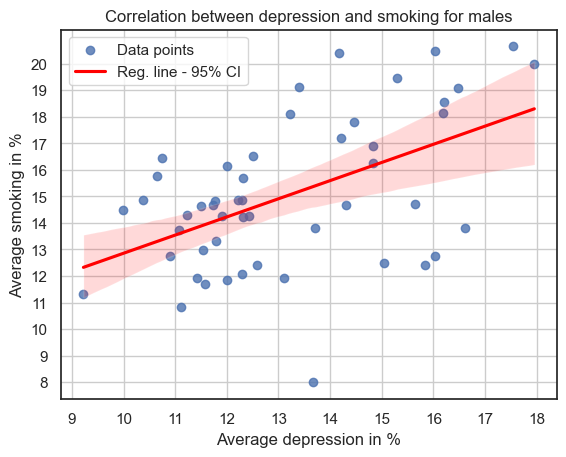

In [32]:
# Creating a regression plot of depression and smoking data for males, with a fitted regression line
sns.regplot(
    data = avg[(avg.index.get_level_values('Stratification2') == 'Male')],
    x = 'Average Depression',
    y = 'Average Smoking',
    ci = 95,
    fit_reg = True,
    line_kws = {'color':'red'},
    truncate = True
)

# Adding labels to the axes
plt.xlabel('Average depression in %')
plt.ylabel('Average smoking in %')

# Adapting the axes ticks according to the data and adding a grid for better visibility
plt.xticks(range(9, 19, 1))
plt.yticks(range(8, 21, 1))
plt.grid()

# Setting the title of the plot and adding a legend
plt.title('Correlation between depression and smoking for males')
plt.legend(['Data points', 'Reg. line - 95% CI'])
plt.show()

In [33]:
# Calculating and showing the pearson correlation coefficient and the p-value for males, to identify if depression and smoking correlates
correlation_coefficient_male, p_value_male = stats.pearsonr(
    avg_depression[(avg_depression.index.get_level_values('Stratification2') == 'Male')],
    avg_smoking[(avg_smoking.index.get_level_values('Stratification2') == 'Male')]
)

correlation_coefficient_male, p_value_male

(0.5102277692883216, 0.0001535303631398037)

### E3-H2: "People living in coastal areas have better mental health"
Author: Deleja-Hotko Julian

Source: White, M./Alcock, I./Wheeler, B./Depledge, M. (2013): Coastal proximity, health and well-being: Results from a longitudinal panel survey, in: Health & Place, vol. 23, pp. 97–103, [\[online\]](https://www.sciencedirect.com/science/article/abs/pii/S1353829213000816?via%3Dihub) doi:10.1016/j.healthplace.2013.05.006  .

In order to analyse this, the dataset first needs to be filtered for states which have a coastline. 
For the purpose of this analysis, states which border on the great lakes will be included in the coastal states.

In [34]:
coastal_states = ['AL', 'AK', 'CA', 'CT', 'DE', 'FL', 'GA', 'HI', 'LA', 'MA', 'MD', 'ME', 'MN', 'MS', 'NC', 'NH', 'NJ', 'NY', 'OR', 'RI', 'SC', 'TX', 'VA', 'WA'] # abbreviations of all states with coastlines
great_lake_states = ['IL', 'IN', 'MI','NY', 'OH', 'OI', 'WI']

df_coastal = df_states[df_states['LocationAbbr'].isin(list(set(coastal_states+great_lake_states)))] # only states which have a coast to either an ocean or the great lakes
df_landlocked = df_states[~df_states['LocationAbbr'].isin(list(set(coastal_states+great_lake_states)))] # only states without any coast

print('Number of coastal states: ', df_coastal['LocationAbbr'].nunique())
print('Number of landlocked states: ', df_landlocked['LocationAbbr'].nunique())

Number of coastal states:  29
Number of landlocked states:  21


Next, the two datasets are reduced to only those with the classification "Mental Health".
This reduces the dataset to only two topics:

In [35]:
df_coastal_mh = df_coastal[df_coastal['Class']=='Mental Health']
df_landlocked_mh = df_landlocked[df_landlocked['Class']=='Mental Health']
print('remaining topics:')
for x in list(set(list(df_coastal_mh['Topic'].unique()) + list(df_landlocked_mh['Topic'].unique()))):
    print(x)

remaining topics:
Lifetime diagnosis of depression
Frequent mental distress


Both of these topics are surveying signs of *low* mental health, meaning that for all of the following analysis, a lower number is indicative of better mental health.

In order to get an overview of the data, boxplots are generated:

In [36]:
# create figure
fig_mh_box = make_subplots(
    rows=1,cols=2,
    subplot_titles=("Coastal Mental Health", "Landlocked Mental Health")
    ,horizontal_spacing=0.075
)

# add the box plot for coastal
fig_mh_box.add_trace(
    go.Box(
        x=df_coastal_mh['Topic'],
        y=df_coastal_mh['Data_Value'],
        name='Coastal',
        customdata=df_coastal_mh['LocationDesc'],
        hovertemplate='<br>Survey: %{x}<br>Value: %{y}%<br>State: %{customdata}',
        boxmean='sd',
        fillcolor='lightblue',
        line=dict(color='cornflowerblue'),
        marker=dict(symbol='line-ew-open',size=10)
    ),
    row=1, col=1
)

# add the box plot for landlocked
fig_mh_box.add_trace(
    go.Box(
        x=df_landlocked_mh['Topic'],
        y=df_landlocked_mh['Data_Value'],
        name='Landlocked',
        customdata=df_landlocked_mh['LocationDesc'],
        hovertemplate='<br>Survey: %{x}<br>Value: %{y}%<br>State: %{customdata}',
        boxmean='sd',
        fillcolor='beige',
        line=dict(color='goldenrod'),
        marker=dict(symbol='line-ew-open',size=10)
    ),
    row=1, col=2
)

# Update layout to include labels
fig_mh_box.update_layout(
    height=750, width=1500, 
    title_text="Comparison of Mental Health surveys responses in coastal states and landlocked states",
    xaxis=dict(title='Topic'),
    xaxis2=dict(title='Topic',matches='x1'),
    yaxis=dict(title='Percentage of affirmative responses (%)'),
    yaxis2=dict(title='Percentage of affirmative responses (%)',matches='y1')
)

fig_mh_box.show()

In these Boxplots, coastal States appear to have slightly better mental health (as demonstrated by lower results), although the outliers (which are present in considerable numbers in all contexts), particularly in terms of depression also appear to be a little higher.

To look further into this, the year-to-year development of both groups is charted.

For readability, the median per topic for each region is used, instead of the 50 different traces for all US states.
The median was chosen as it is less affected by the previously noted not insignificant number of outliers.

In [37]:
def prepare_line_data(df, label):
    df_median = df.groupby(['YearEnd', 'Topic']).agg({'Data_Value':'median'}).reset_index()
    df_median['Label'] = label
    return df_median

df_coastal_line = prepare_line_data(df_coastal_mh, 'Coastal')
df_landlocked_line = prepare_line_data(df_landlocked_mh, 'Landlocked')
df_combined = pd.concat([df_coastal_line, df_landlocked_line])

color_map = {
    'Coastal - Lifetime diagnosis of depression': 'skyblue',
    'Coastal - Frequent mental distress': 'cornflowerblue',
    'Landlocked - Lifetime diagnosis of depression': 'lightsalmon',
    'Landlocked - Frequent mental distress': 'indianred'
}

# create column 'color' which maches the keys of the color_map dictionary
df_combined['Color'] = df_combined['Label'] + ' - ' + df_combined['Topic']

# create line plot
fig_line = px.line(df_combined, x='YearEnd', y='Data_Value', color='Color',
                   color_discrete_map=color_map,
                   labels={'Data_Value': 'Mean Data Value', 'YearEnd': 'Year'},
                   title='Mean Data Value Over Years by Topic and State Type')

# Update layout to include labels
fig_line.update_layout(
    height = 500, width = 1100, 
    title_text = "Development over time of reported mental health issues",
    xaxis = dict(title = 'Year'),
    yaxis = dict(title = 'Median percentage of affirmative responses (%)'),
)

fig_line.show()

Here, landlocked countries can be seen to consistently have higher (meaning worse) results for depression diagnoses, whereas reported figures of frequent mental distress are very similar for most of the time period, with landlocked countries again diverging upward in the more recent years.

Now to perform statistical tests:

Before the actual tests can be done, The dataframes are further split up according to the topic, to create one dataframe per survey.

In [38]:
df_coastal_mh_dep = df_coastal_mh[df_coastal_mh['Topic']=='Lifetime diagnosis of depression']['Data_Value'].dropna()
df_coastal_mh_dist = df_coastal_mh[df_coastal_mh['Topic']=='Frequent mental distress']['Data_Value'].dropna()
df_landlocked_mh_dep = df_landlocked_mh[df_landlocked_mh['Topic'] == 'Lifetime diagnosis of depression']['Data_Value'].dropna()
df_landlocked_mh_dist = df_landlocked_mh[df_landlocked_mh['Topic']=='Frequent mental distress']['Data_Value'].dropna()

First a staticstical test for depression:

In [39]:
dep_corr, dep_p_value = stats.ttest_ind(df_landlocked_mh_dep, df_coastal_mh_dep,equal_var=False)

print(f'Correlation coefficient: {dep_corr:.5f}\np-value: {dep_p_value}')

Correlation coefficient: 5.71787
p-value: 1.145001612232638e-08


A positive coefficient indicates that the survey results for the topic "Lifetime diagnosis of depression" are higher (meaning worse) in landlocked states compared to coastal states.
The magnitude of the coefficient (5.718) suggests a relatively large difference between the groups.

A p-value of 1.145e−8 is extremely small and far below the significance level of 0.05.  Therefore the null hypothesis can be rejected with a high level of confidence. This means there is statistically significant evidence to suggest that being a coastal or landlocked state is associated with differences in the reported values for "Lifetime diagnosis of depression."

Secondly, repeating the test for general forms of mental distress:

In [40]:
dist_corr, dist_p_value = stats.ttest_ind(df_landlocked_mh_dist, df_coastal_mh_dist, equal_var=False)

print(f'Correlation coefficient: {dist_corr:.5f}\np-value: {dist_p_value}')

Correlation coefficient: 1.22687
p-value: 0.21994534467697138


The positive coefficient of 1.227 indicates that reports of frequent mental distress are also higher in landlocked states, albeit to a much lower degree than figures for depression.

However, a p-value of 0.22 is well above the significance level of 0.05, meaning there is a substantial possibility that this result is simply due to random chance rather than any correlation. 

In conclusion, while residents of states with coastline report consistently lower numbers of having been diagnosed with types of depression, no clear link between proximity to a coastline and more generalized forms of mental distress can be established.

### E3-H3: "Assessing the Correlation Between Gambling Prevalence and Health Outcomes in Nevada: A Comparative Analysis with the U.S. Population"
Author: Topór Karol


The state of Nevada, with its high concentration of gambling activities, particularly in Las Vegas, presents a unique case for examining the interrelation between gambling habits and health outcomes. Gambling, often associated with a range of psychosocial stresses, may contribute to or exacerbate health issues, although the relationship is not straightforward and is influenced by numerous factors. This thesis posits that while gambling activities in Nevada are a central aspect of its social and economic fabric, they may also be indirectly correlated with certain health issues, such as mental distress and substance use. 

Consequently, the selected health categories—'Overall Health,' 'Mental Health,' 'Smoking and Alcohol Use,' 'Nutrition/Physical Activity/Obesity,' and 'Cognitive Decline'—along with their respective subtopics, have been visualized and subjected to comparative analysis.


In [41]:
health_class = ['Overall Health', 'Mental Health', 'Smoking and Alcohol Use', 'Nutrition/Physical Activity/Obesity', 'Cognitive Decline']
exclude_topics = [
                  'Need assistance with day-to-day activities because of subjective cognitive decline or memory loss', 
                  'Functional difficulties associated with subjective cognitive decline or memory loss among older adults',
                  'Talked with health care professional about subjective cognitive decline or memory loss'
                ]

In [42]:
# Prepare df's
df_nevada = df_states[
  (df_states['Data_Value_Unit'] == '%') &
  (df_states['LocationAbbr'] == 'NV') & 
  (df_states['Class'].isin(health_class)) &
  ~(df_states['Topic'].isin(exclude_topics))
]

df_rest_of_us = df_territories[
  (df_territories['Data_Value_Unit'] == '%') &
  (df_territories['LocationAbbr'] == 'US') & 
  (df_territories['Class'].isin(health_class)) &
  ~(df_territories['Topic'].isin(exclude_topics))
]

df_states_topic_mean = df_states[(df_states['Data_Value_Unit'] == '%') & (df_states['YearStart'] == 2021)].groupby(['LocationDesc', 'Topic'])['Data_Value'].mean().reset_index()
df_states_topic_mean_gdf = gdf.merge(df_states_topic_mean, left_on='NAME', right_on='LocationDesc')

In [43]:
topics_of_interest = [
    'Current smoking', 
    'Binge drinking within past 30 days', 
    'Frequent mental distress'
]

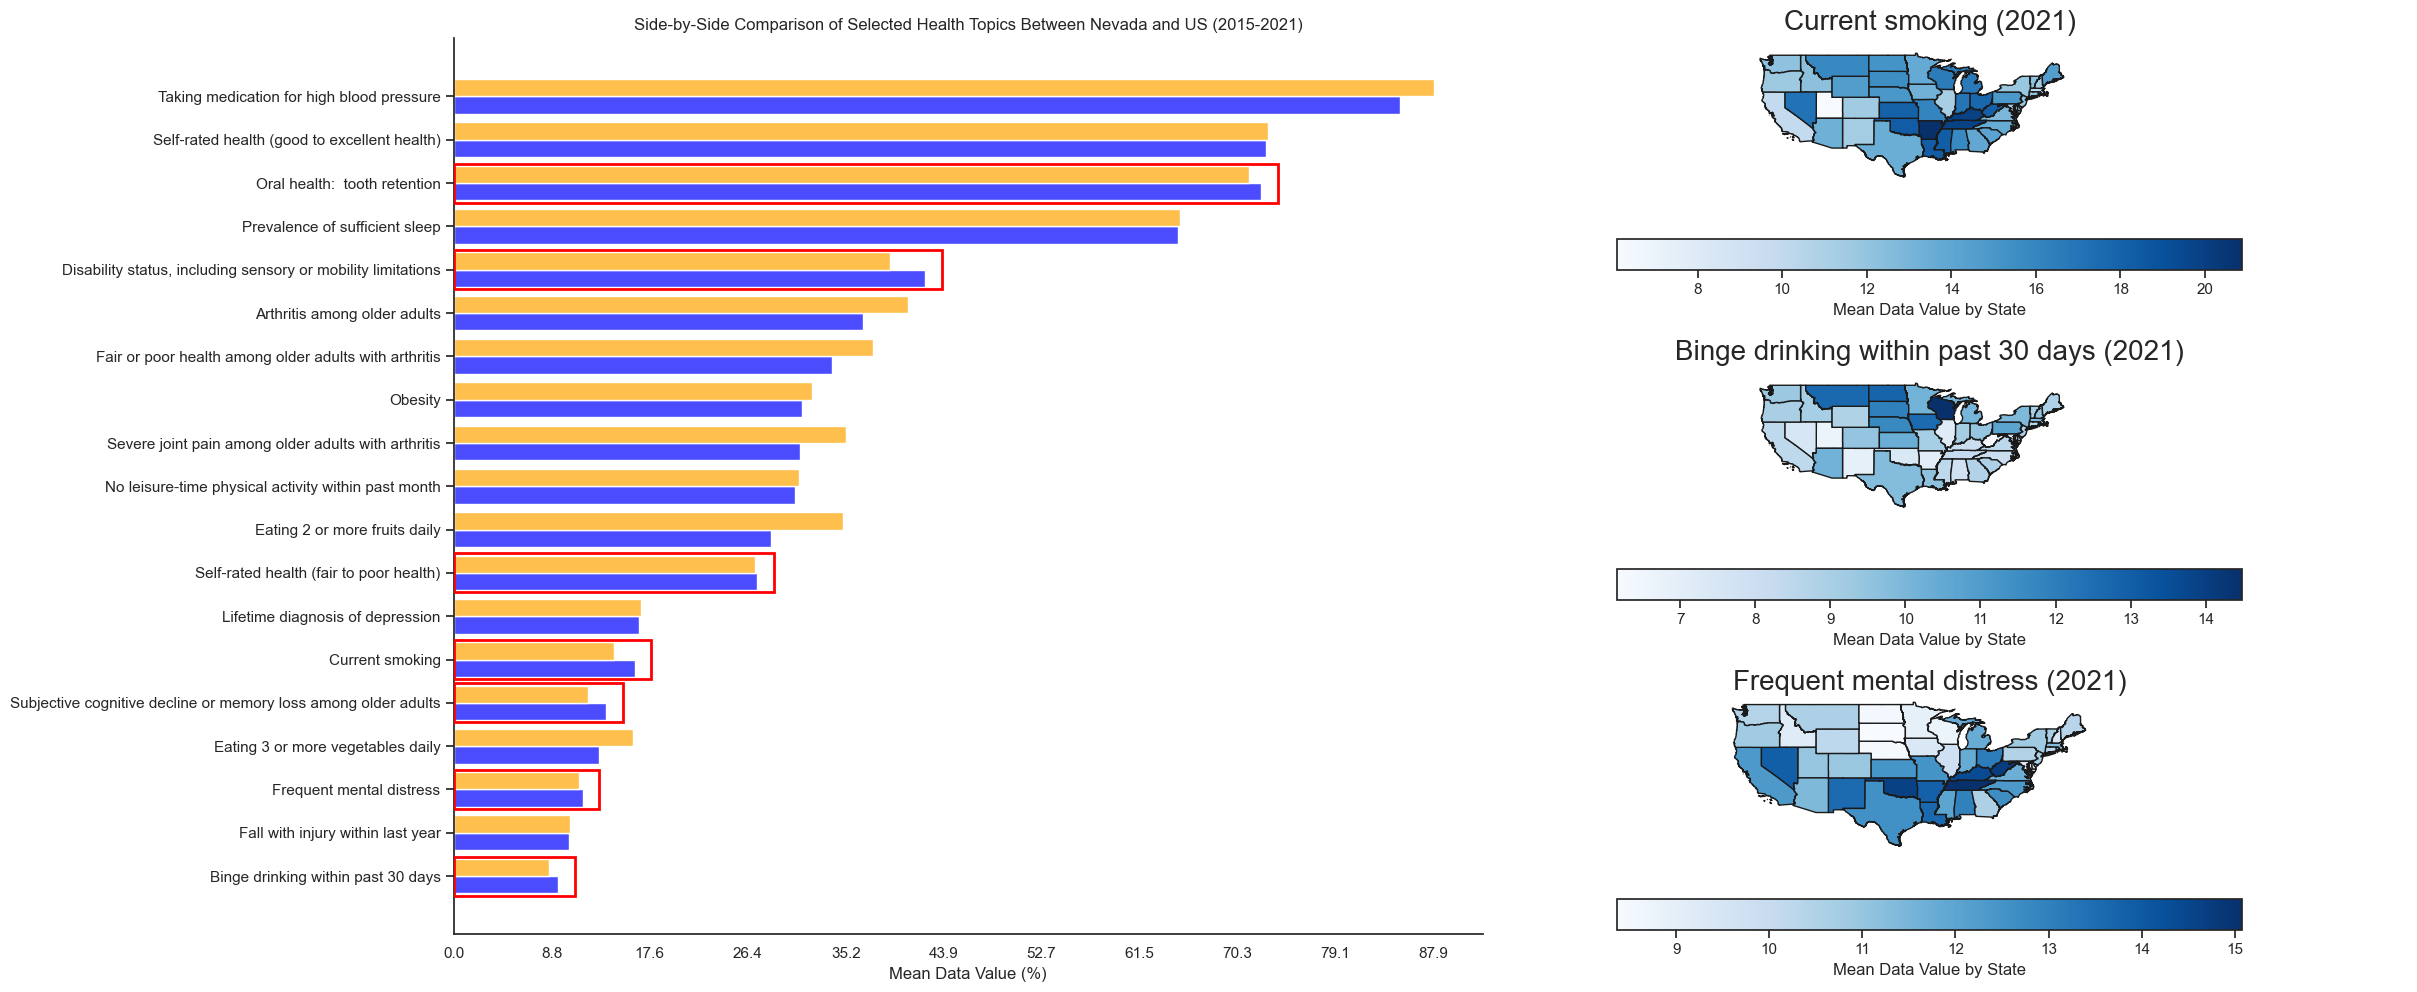

In [44]:
# Get mean Data_Value for state Nevada for year 2015 to 2021
df_nevada_grouped = df_nevada.groupby(['LocationDesc', 'Topic'])['Data_Value'].mean().reset_index().sort_values(by='Data_Value')
# Get mean Data_Value for all US states for year 2015 to 2021
df_rest_of_us_grouped = df_rest_of_us.groupby(['LocationDesc', 'Topic'])['Data_Value'].mean().reset_index().sort_values(by='Data_Value')

# Merging the filtered dataframes
df_combined = pd.merge(df_nevada_grouped, df_rest_of_us_grouped, on='Topic', suffixes=('_Nevada', '_US'))
df_combined.rename(columns={'Data_Value_Nevada': 'Nevada', 'Data_Value_US': 'US'}, inplace=True)

# Plotting the side-by-side unstacked bar chart with flipped axes
fig = plt.figure(figsize=(25, 10))
ax1 = fig.add_subplot(121)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)

# Setting the positions for the bars
pos = range(len(df_combined))
bar_width = 0.4  # width of the bars

# Plotting Nevada bars
nevada_bars = ax1.barh([p - bar_width/2 for p in pos], df_combined['Nevada'], height=bar_width, label='Nevada', color='#4C4CFF')
# Plotting US bars
us_bars = ax1.barh([p + bar_width/2 for p in pos], df_combined['US'], height=bar_width, label='US', color='#FFBF4C')

ax1.set_yticks([p for p in pos])
ax1.set_yticklabels(df_combined['Topic'])
ax1.set_xlabel('Mean Data Value (%)')
ax1.set_title('Side-by-Side Comparison of Selected Health Topics Between Nevada and US (2015-2021)')

max_value = max(df_combined['Nevada'].max(), df_combined['US'].max())
ax1.set_xticks(np.arange(0, max_value + 1, step=max_value / 10))  # Adjust step as necessary
ax1.set_xticklabels(["{:.1f}".format(x) for x in np.arange(0, max_value + 1, step=max_value / 10)])

# Adding rectangles
for i, (nevada_bar, us_bar) in enumerate(zip(nevada_bars, us_bars)):
    if nevada_bar.get_width() > us_bar.get_width():
        # Add a rectangle around the Nevada bar
        plt.gca().add_patch(
            patches.Rectangle(
                (0, nevada_bar.get_y() - 0.05),
                nevada_bar.get_width() + 1.5,
                0.9,
                linewidth=2,
                edgecolor='red',
                facecolor='none',
                zorder=5
            )
        )

ax1.yaxis.tick_left()

# Geoplot on the right
ax2 = fig.add_subplot(122, aspect='equal')
ax2.set_axis_off()

# Remove the border of the subplot
for spine in ax2.spines.values():
    spine.set_visible(False)

num_rows = len(topics_of_interest)
grid_specs = fig.add_gridspec(nrows=num_rows, ncols=1, left=0.65, right=0.9, wspace=0, hspace=0.4)

for i, topic in enumerate(topics_of_interest):
    ax = fig.add_subplot(grid_specs[i, 0], aspect='equal')

    # Filtering the data for the current topic
    df_filtered = df_states_topic_mean_gdf[df_states_topic_mean_gdf['Topic'] == topic]

    # Plotting the geodata for the topic
    df_filtered.plot(column='Data_Value', ax=ax, legend=True,
                     legend_kwds={'label': "Mean Data Value by State", 'orientation': "horizontal"},
                     cmap='Blues', edgecolor='k')

    ax.set_title(f'{topic} (2021)', fontsize=20)
    ax.set_xlim(-120, -65)
    ax.set_ylim(23, 50)
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_axis_off()

plt.tight_layout()
plt.show()


The barplot in Figure X highlights a side-by-side comparison of health indicators between Nevada and the U.S. overall, color-coded for clarity with Nevada in blue, the U.S. in orange, and red borders indicating where Nevada's mean values are notably higher. These findings predominantly pertain to mental health and lifestyle-related diseases, suggesting potential adverse health impacts linked to Nevada's gambling culture.

The 2021 geoplots for 'Current smoking', 'Binge drinking within past 30 days', and 'Frequent mental distress'—factors often related to gambling—show Nevada as consistently high-ranking, though not leading, in these health concerns. The exception is 'Binge drinking within past 30 days', where Nevada's rates are relatively lower. This evidence supports the thesis that the gambling environment in Nevada is a significant, though complex, contributor to specific health issues.

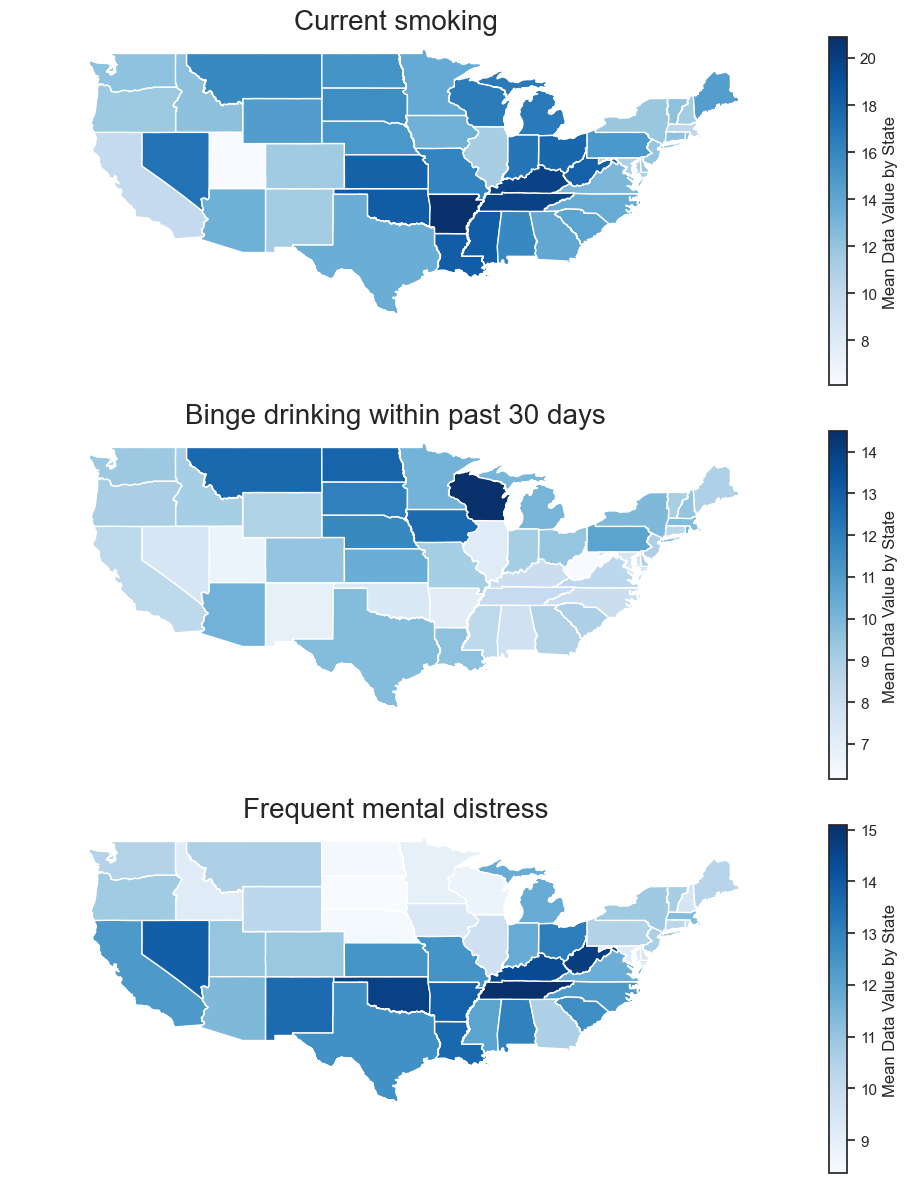

In [45]:
###########################################################
# Rest of the analysys, which did not fit into the report #
###########################################################

# Adjust the layout to 3 rows
num_rows = 3
num_cols = (len(topics_of_interest) + num_rows - 1) // num_rows  # Ceiling division to distribute the plots

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10 * num_cols, 4 * num_rows))

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

for i, topic in enumerate(topics_of_interest):
    ax = axes_flat[i]
    if topic == 'Talked with health care professional about subjective cognitive decline or memory loss':
      ax = axes_flat[i+1]
        
    df_states_topic_mean_gdf[df_states_topic_mean_gdf['Topic'] == topic].plot(column='Data_Value', ax=ax, legend=True,
                legend_kwds={
                  'label': "Mean Data Value by State",
                  'orientation': "vertical"
                  },
                cmap='Blues'  
              )
    
    ax.set_title(topic, fontsize=20)
    ax.set_xlim(-130, -65)
    ax.set_ylim(20, 50)
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_axis_off()

# Turn off axes for any empty subplots
for j in range(i, num_rows*num_cols):
    axes_flat[j].set_axis_off()

plt.tight_layout()
plt.show()

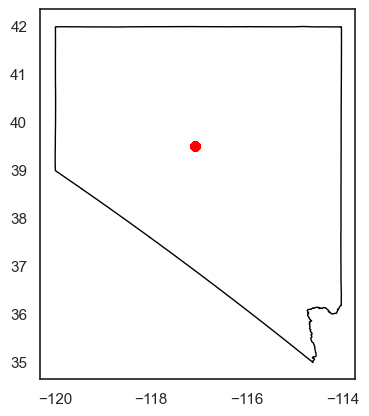

In [46]:
# Gilter df_nevada for topics of intrest and convert it to geodataframe to plot the points
df_nevada_topics_of_intrest = df_nevada[df_nevada['Topic'].isin(topics_of_interest)]
df_nevada_topics_of_intrest['Geolocation'] = df_nevada_topics_of_intrest['Geolocation'].apply(wkt.loads)
gdf_points = gpd.GeoDataFrame(df_nevada_topics_of_intrest, geometry='Geolocation')

gdf_nevada = gdf[gdf['STUSPS'] == 'NV'] #gdf.merge(df_nevada_mean, left_on='NAME', right_on='LocationDesc')

ax = gdf_nevada.plot(color='white', edgecolor='black')
gdf_points.plot(ax=ax, color='red', marker='o')
ax.set_aspect('equal')

plt.show()


In [66]:
topics_of_interest = [
    'Current smoking', 
    'Binge drinking within past 30 days', 
    'Frequent mental distress', 
    'Disability status, including sensory or mobility limitations', 
    'Self-rated health (fair to poor health)', 
    'Subjective cognitive decline or memory loss among older adults', 
    'Talked with health care professional about subjective cognitive decline or memory loss'
]

# Filter df's
df_nevada_topics_of_interest = df_nevada[df_nevada['Topic'].isin(topics_of_interest)]
df_rest_of_us_topics_of_interest = df_rest_of_us[df_rest_of_us['Topic'].isin(topics_of_interest)]

# Get mean Data_Value for state Nevada by year (2015 - 2021)
df_nevada_toi_grouped = df_nevada_topics_of_interest.groupby(['YearStart', 'Topic'])['Data_Value'].mean().reset_index().sort_values(by='YearStart')
# Get mean Data_Value for state Nevada by year (2015 - 2021)
df_rest_of_us_toi_grouped = df_rest_of_us_topics_of_interest.groupby(['YearStart', 'Topic'])['Data_Value'].mean().reset_index().sort_values(by='YearStart')

colors_nevada = ['#0000FF', '#0040FF', '#0080FF', '#00BFFF', '#1E90FF', '#4169E1', '#4682B4']
colors_rest_of_us = ['#FF4500', '#FF6347', '#FF7F50', '#FF8C00', '#FFA500', '#FFD700', '#FFDEAD']
markers = ['o', 'D', '^', 'x', '>', 's', '*']

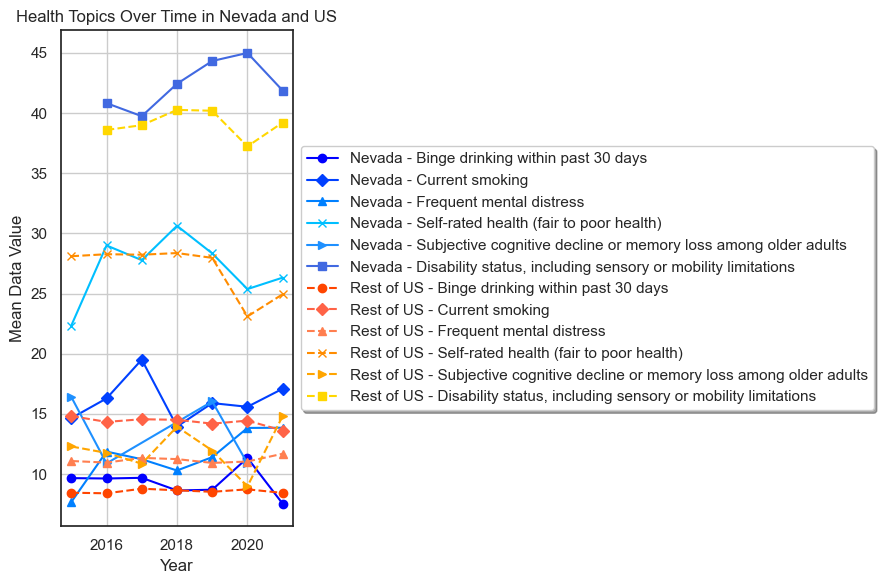

In [49]:
# Create a figure for combined plots
fig, ax = plt.subplots(figsize=(9, 6))

# Plot for Nevada
for i, topic in enumerate(df_nevada_toi_grouped['Topic'].unique()):
    topic_data = df_nevada_toi_grouped[df_nevada_toi_grouped['Topic'] == topic]
    ax.plot(topic_data['YearStart'], topic_data['Data_Value'], label=f"Nevada - {topic}", color=colors_nevada[i % len(colors_nevada)], marker=markers[i % len(markers)])

# Plot for Rest of US
for i, topic in enumerate(df_rest_of_us_toi_grouped['Topic'].unique()):
    topic_data = df_rest_of_us_toi_grouped[df_rest_of_us_toi_grouped['Topic'] == topic]
    ax.plot(topic_data['YearStart'], topic_data['Data_Value'], label=f"Rest of US - {topic}", linestyle='--', color=colors_rest_of_us[i % len(colors_rest_of_us)], marker=markers[i % len(markers)])

ax.set_title('Health Topics Over Time in Nevada and US')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Data Value')
ax.grid(True)

# Place the legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True)

# Adjust layout
plt.tight_layout()

plt.show()

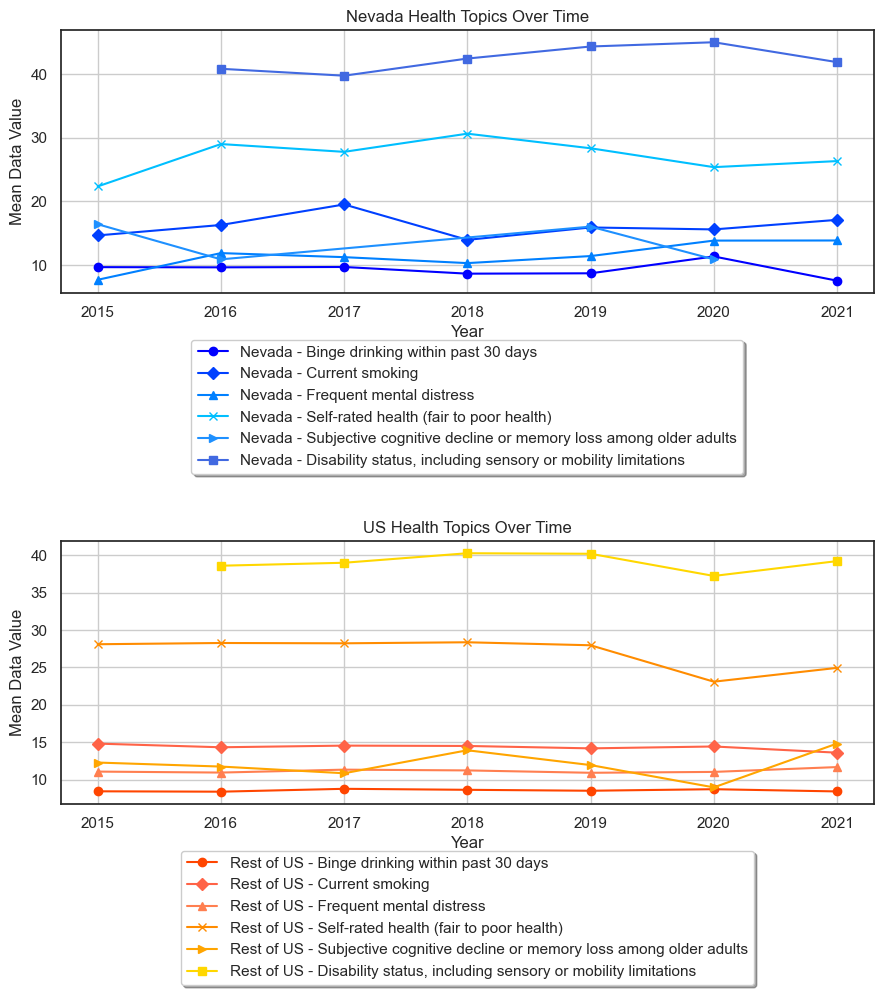

In [50]:
# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 13))

# Plot for Nevada in the first subplot
for i, topic in enumerate(df_nevada_toi_grouped['Topic'].unique()):
    topic_data = df_nevada_toi_grouped[df_nevada_toi_grouped['Topic'] == topic]
    ax1.plot(topic_data['YearStart'], topic_data['Data_Value'], label=f"Nevada - {topic}", color=colors_nevada[i % len(colors_nevada)], marker=markers[i % len(markers)])
ax1.set_title('Nevada Health Topics Over Time')
ax1.set_xlabel('Year')
ax1.set_ylabel('Mean Data Value')
ax1.grid(True)

# Plot for Rest of US in the second subplot
for i, topic in enumerate(df_rest_of_us_toi_grouped['Topic'].unique()):
    topic_data = df_rest_of_us_toi_grouped[df_rest_of_us_toi_grouped['Topic'] == topic]
    ax2.plot(topic_data['YearStart'], topic_data['Data_Value'], label=f"Rest of US - {topic}", color=colors_rest_of_us[i % len(colors_rest_of_us)], marker=markers[i % len(markers)])
ax2.set_title('US Health Topics Over Time')
ax2.set_xlabel('Year')
ax2.set_ylabel('Mean Data Value')
ax2.grid(True)

# Place the legend at the bottom of the plot
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=1)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=1)

# Adjust layout
plt.tight_layout(rect=[0, 0.1, 1, 0.9])

plt.show()

The provided visualizations depict the temporal evolution of seven health-related topics from 2015 to 2021, where the mean data values for the state of Nevada consistently exceeded those of the overall United States, as previously demonstrated. Initial analysis reveals a relative stability in the health metrics of the aggregate U.S. data, with the exception of 'Subjective cognitive decline or memory loss among older adults,' which exhibits significant fluctuation. In contrast, the Nevada-specific data presents a more dynamic profile, with metrics intersecting and diverging over the years, possibly reflecting the state's unique socioeconomic and environmental factors.

Notably, 'Binge drinking within past 30 days' experienced a pronounced surge in 2020 within Nevada, subsequently declining to the lowest point observed within the six-year span. This abrupt variation could be attributable to behavioral shifts induced by external events or policy changes. Similarly, 'Frequent mental distress' displayed an upward trend commencing in 2019, culminating in a peak in 2021, potentially signaling emergent health challenges within the state.

The trajectory of 'Self-rated health (fair to poor health)' decreased in both Nevada and the broader U.S. from 2019, with a slight rebound post-2020. This pattern may be tentatively associated with the widespread impact of the COVID-19 pandemic, reflecting its implications on public perception of health and well-being. Such observations underscore the value of longitudinal health data in discerning trends and informing public health interventions, particularly in locales with distinct lifestyle attributes such as Nevada.

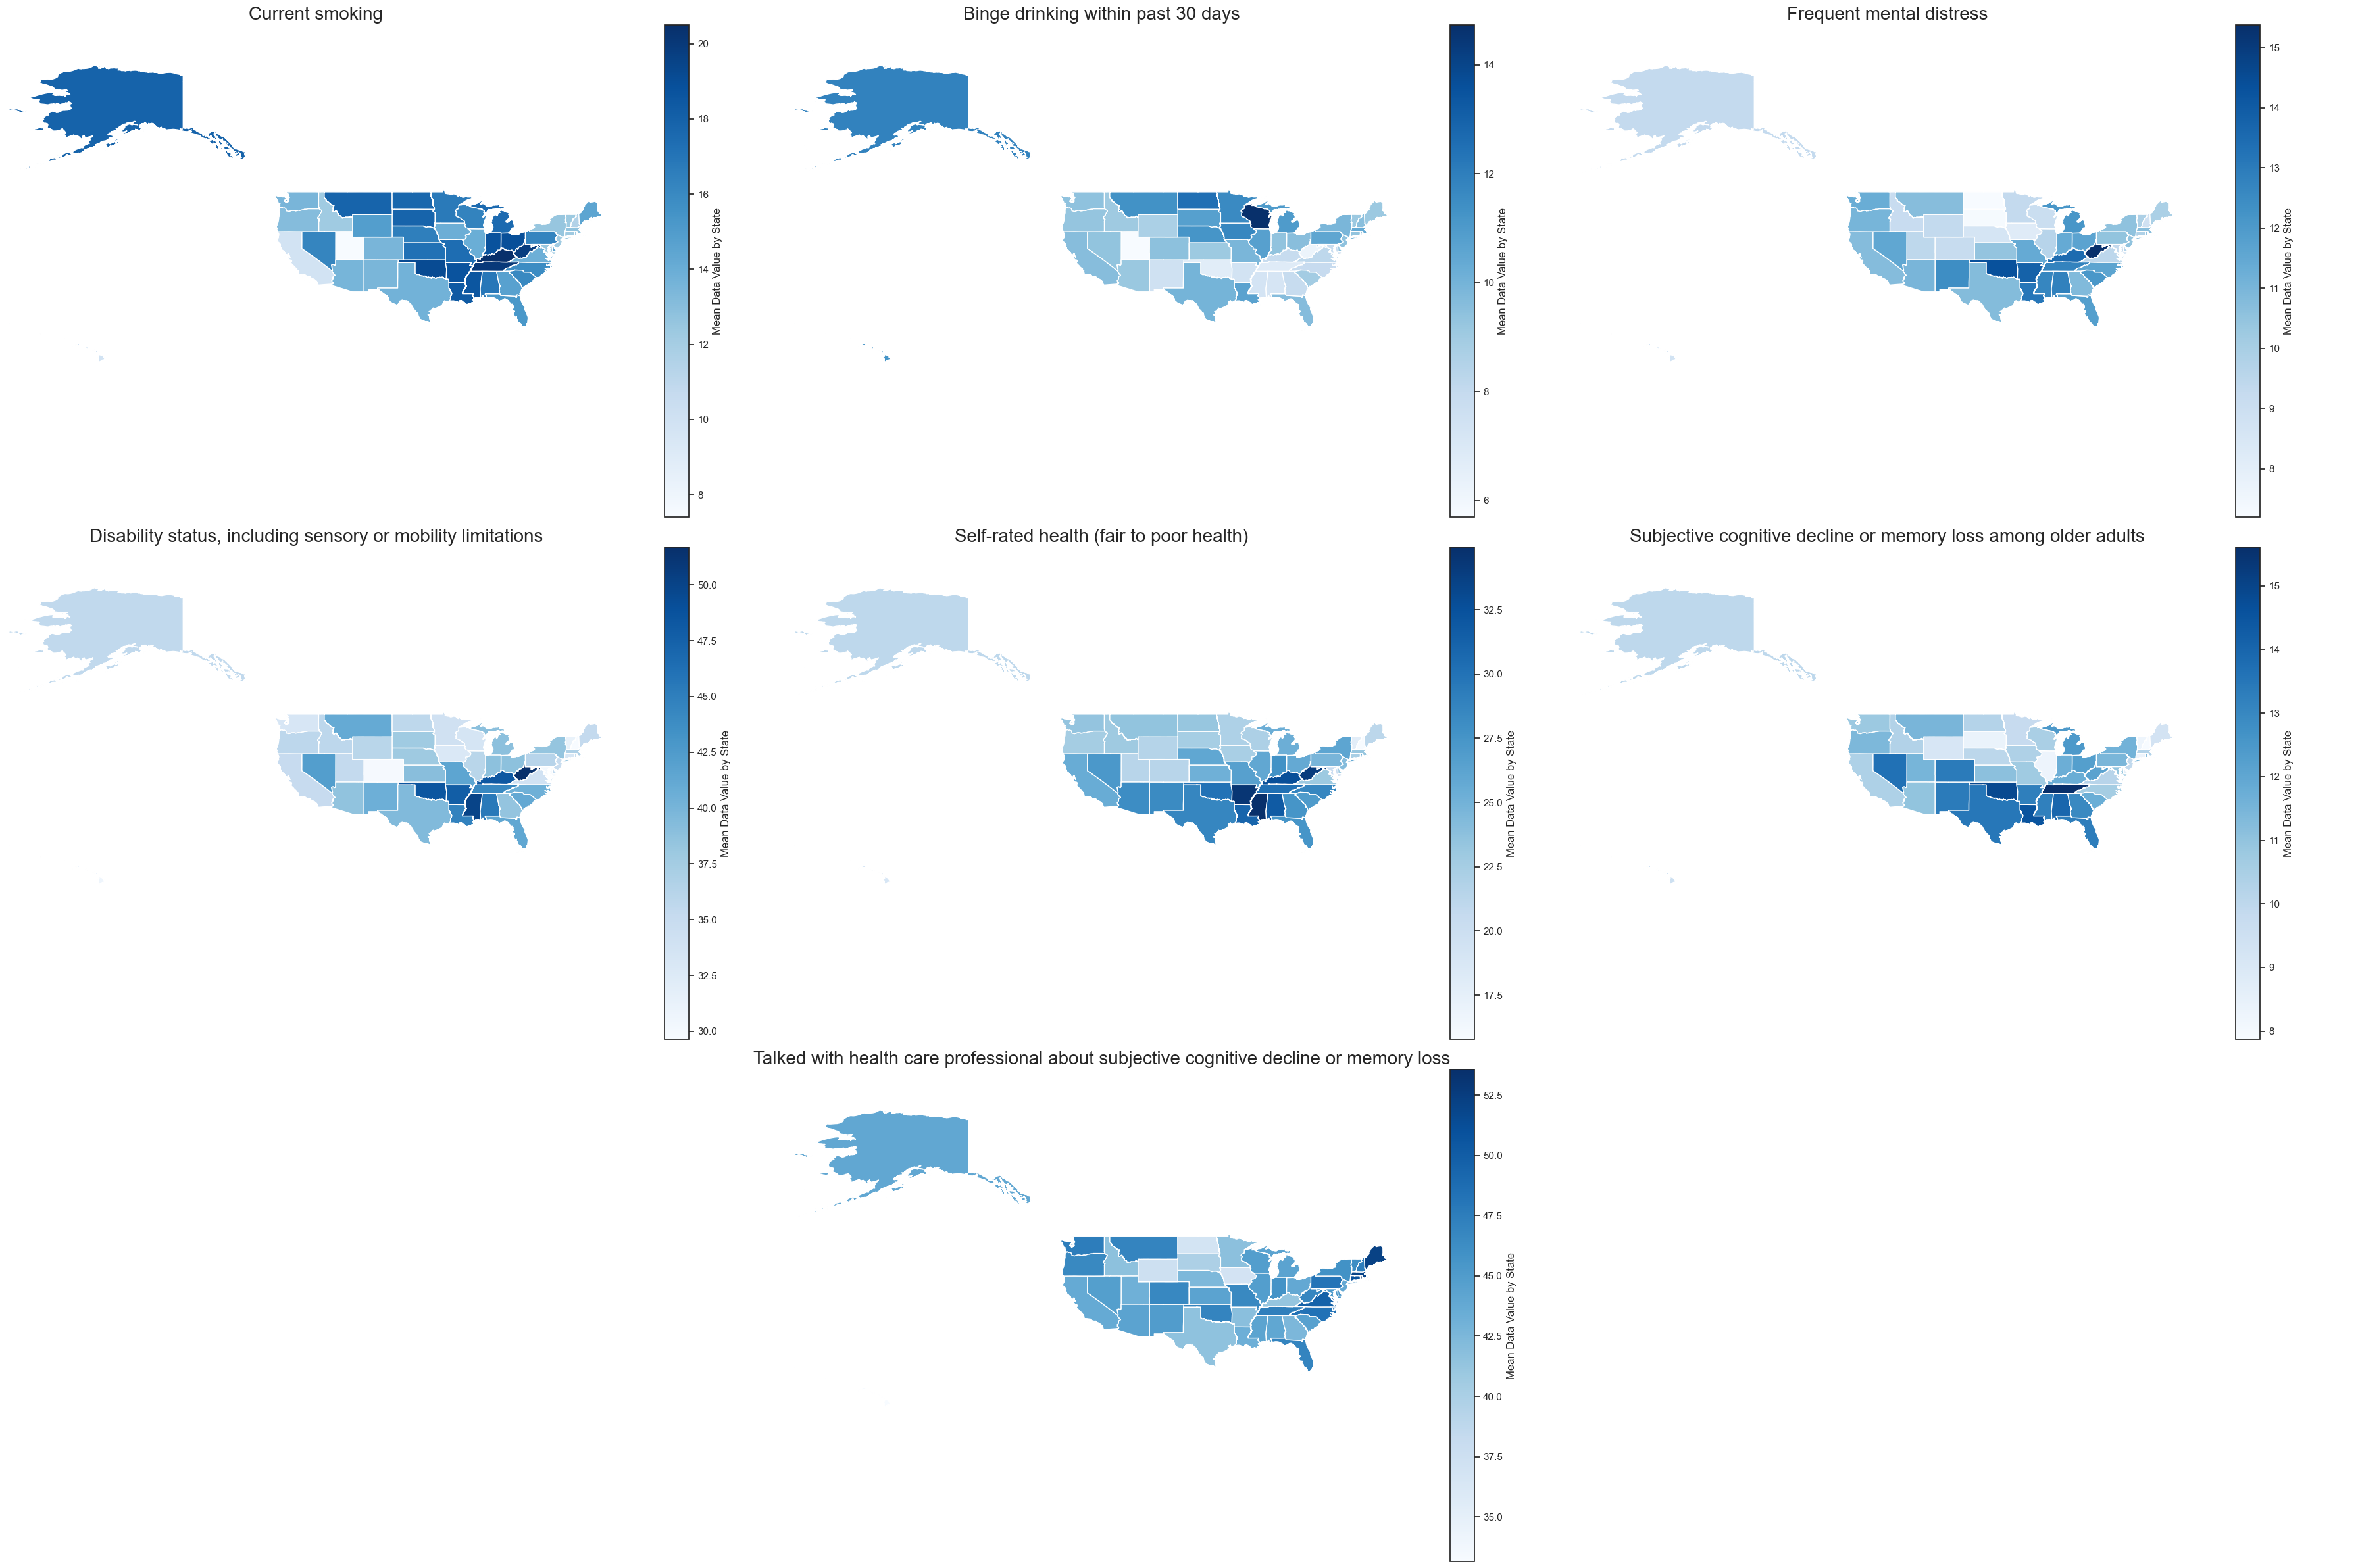

In [51]:
# Prepare the mean Data_Value for each state and topic
df_states_topic_mean = df_states[(df_states['Data_Value_Unit'] == '%')].groupby(['LocationDesc', 'Topic'])['Data_Value'].mean().reset_index()
df_states_topic_mean_gdf = gdf.merge(df_states_topic_mean, left_on='NAME', right_on='LocationDesc')

# Adjust the layout to 3 rows
num_rows = 3
num_cols = (len(topics_of_interest) + num_rows - 1) // num_rows  # Ceiling division to distribute the plots

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12 * num_cols, 8 * num_rows))

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

for i, topic in enumerate(topics_of_interest):
    ax = axes_flat[i]
    if topic == 'Talked with health care professional about subjective cognitive decline or memory loss':
      ax = axes_flat[i+1]
        
    df_states_topic_mean_gdf[df_states_topic_mean_gdf['Topic'] == topic].plot(column='Data_Value', ax=ax, legend=True,
                legend_kwds={
                  'label': "Mean Data Value by State",
                  'orientation': "vertical"
                  },
                cmap='Blues'  
              )
    
    ax.set_title(topic, fontsize=20)
    ax.set_xlim(-170, -65)
    ax.set_ylim(20, 50)
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_axis_off()

# Turn off axes for any empty subplots
for j in range(i, num_rows*num_cols):
    axes_flat[j].set_axis_off()

plt.tight_layout()
plt.show()

The series of choropleth maps presented visualize the mean data values for seven key health topics across the United States, with a specific focus on the state of Nevada from 2015 to 2021. While Nevada does not consistently register the highest values, it is evident that it ranks among the upper echelons in nearly every health topic evaluated. This pattern could reflect underlying regional health dynamics and warrants a closer examination of Nevada's public health policies, healthcare access, and lifestyle factors that may contribute to these outcomes.

From the graphical representation, there is a discernible trend where Nevada's values for 'Current smoking' and 'Binge drinking within past 30 days' are notably elevated, which might be aligned with lifestyle choices prevalent in the state's entertainment-centric culture. Moreover, the relatively high values in 'Frequent mental distress' and 'Self-rated health (fair to poor health)' could suggest a correlation with stress-related factors, potentially exacerbated by the economic and social environment characteristic of Nevada.

Furthermore, the maps relating to 'Disability status, including sensory or mobility limitations,' 'Subjective cognitive decline or memory loss among older adults,' and 'Talked with health care professional about subjective cognitive decline or memory loss' suggest that despite not reaching the highest values, the state's figures are significantly prominent. This continued pattern indicates a persistent need for targeted health interventions and resource allocations tailored to Nevada's demographic and socioeconomic composition.

Overall, these maps offer a stark visualization of the state's health status in comparison to the national landscape, providing a foundational basis for a more in-depth analysis that could explore the multifaceted influences impacting health outcomes in regions with unique social and economic environments, such as Nevada.

In [52]:
# prepare df's
df_nevada_gender = df_nevada_topics_of_interest[df_nevada_topics_of_interest['StratificationCategory2'] == 'Gender'].groupby(['Stratification2', 'Topic'])['Data_Value'].mean().reset_index().dropna()
df_nevada_ethnicity = df_nevada_topics_of_interest[df_nevada_topics_of_interest['StratificationCategory2'] == 'Race/Ethnicity'].groupby(['Stratification2', 'Topic'])['Data_Value'].mean().reset_index().dropna()
df_nevada_age = df_nevada_topics_of_interest.groupby(['Stratification1', 'Topic'])['Data_Value'].mean().reset_index().dropna()

# Filter for only three topics
topics_of_interest_striped = topics_of_interest[0:3]

In the subsequent and final section of this hypothesis, we investigate three health topics that are frequently associated with gambling behaviors: 'Current Smoking,' 'Binge Drinking Within Past 30 Days,' and 'Frequent Mental Distress.' These topics are analyzed with respect to demographic stratifications, namely gender, ethnicity, and age, to discern patterns and correlations that may inform the relationship between gambling prevalence and health outcomes within these distinct population segments.


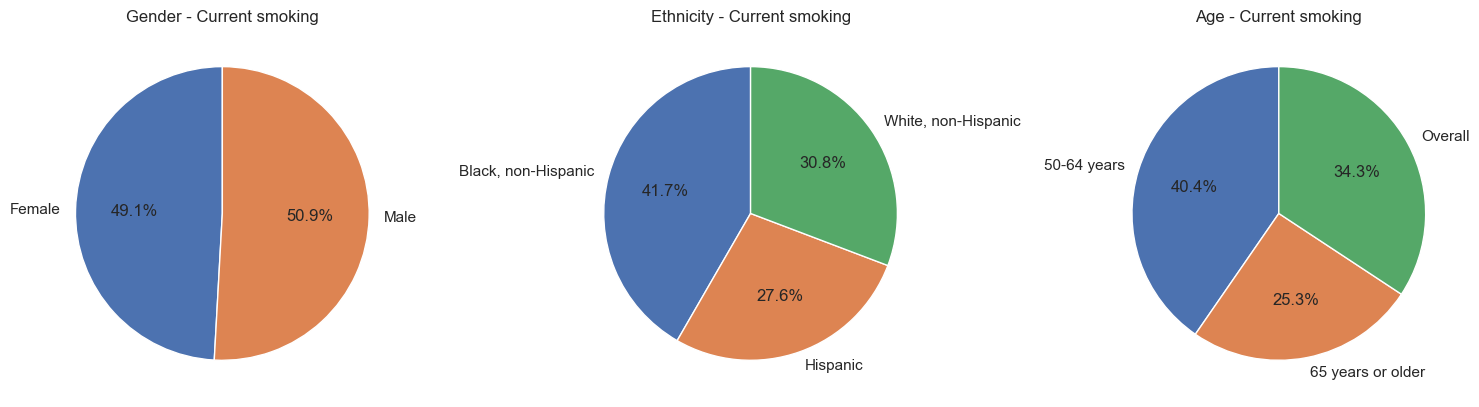

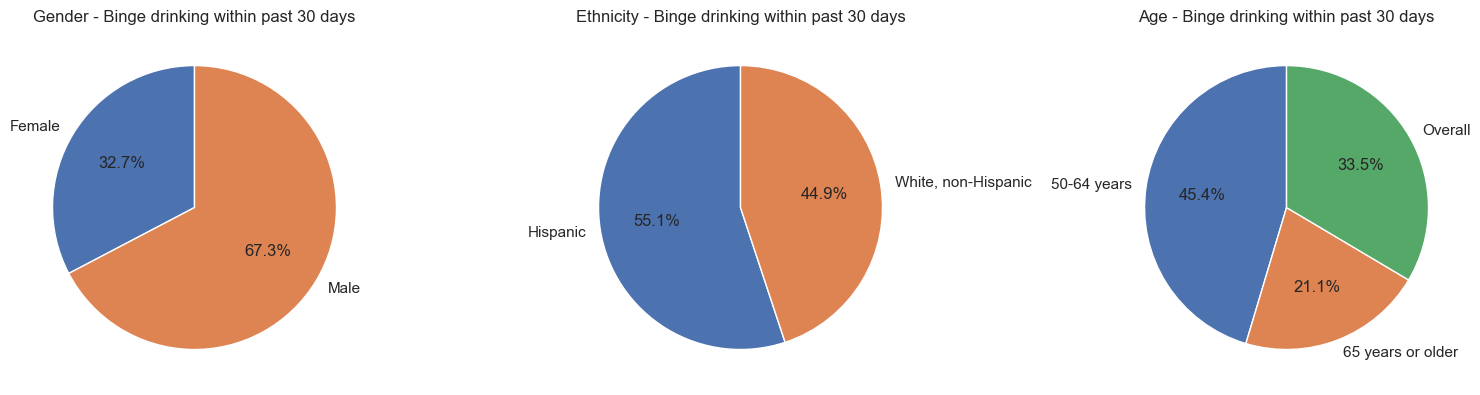

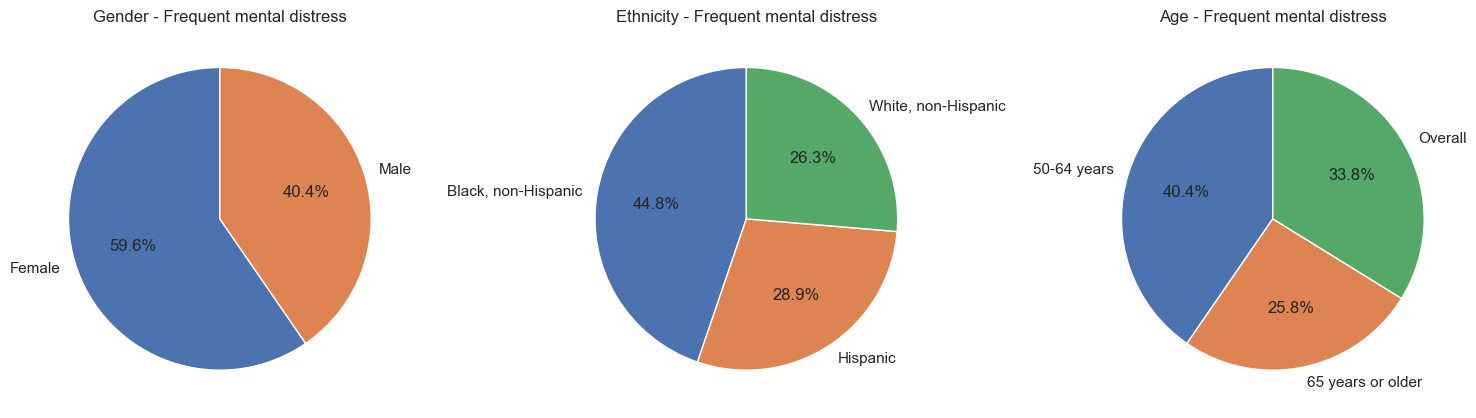

<Figure size 640x480 with 0 Axes>

In [53]:

# Create a figure with subplots - one row per topic
for topic in topics_of_interest_striped:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  # One row, three columns for each plot

    # Gender distribution pie chart for the topic
    gender_data = df_nevada_gender[df_nevada_gender['Topic'] == topic]
    gender_distribution = gender_data.groupby('Stratification2')['Data_Value'].sum()
    axes[0].pie(gender_distribution, labels=gender_distribution.index, autopct='%1.1f%%', startangle=90)
    axes[0].set_title(f'Gender - {topic}')

    # Ethnicity distribution pie chart for the topic
    ethnicity_data = df_nevada_ethnicity[df_nevada_ethnicity['Topic'] == topic]
    ethnicity_distribution = ethnicity_data.groupby('Stratification2')['Data_Value'].sum()
    axes[1].pie(ethnicity_distribution, labels=ethnicity_distribution.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title(f'Ethnicity - {topic}')

    # Age distribution pie chart for the topic
    age_data = df_nevada_age[df_nevada_age['Topic'] == topic]
    age_distribution = age_data.groupby('Stratification1')['Data_Value'].sum()
    axes[2].pie(age_distribution, labels=age_distribution.index, autopct='%1.1f%%', startangle=90)
    axes[2].set_title(f'Age - {topic}')

    # Show the plot for the current topic
    plt.tight_layout()
    plt.show()

# plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()

#### 1'st plot
The pie charts presented herein offer a demographic breakdown of 'Current Smoking' prevalence within Nevada. The gender distribution is approximately equal, with females constituting 49.1% and males 50.9%, indicating parity in smoking habits across genders. The ethnicity distribution, however, reveals a more skewed pattern, with only three ethnic groups—'Black, non-Hispanic,' 'White, non-Hispanic,' and 'Hispanic'—represented in the data. The absence of other ethnic groups such as 'Asian/Pacific Islander' and 'Native American/Alaskan Native' may suggest a limitation in the survey's reach or participation within these communities in Nevada. Notably, the 'Black, non-Hispanic' group comprises a significant proportion of the smoking demographic at 41.7%, followed by 'White, non-Hispanic' at 30.8%, and 'Hispanic' at 27.6%.

In terms of age distribution, individuals aged between 50-64 years account for the largest share of smokers at 40.4%, with those aged 65 and over representing 25.3%. The category labeled 'Overall' provides an average across the two age demographics, offering a general view of smoking prevalence across age groups. This demographic analysis highlights the importance of tailored public health interventions that consider the varied smoking rates across different ethnicities and age groups.

#### 2'th plot
The presented pie charts provide a demographic analysis of 'Binge Drinking within Past 30 Days' in Nevada. The gender distribution reveals a substantial majority of males (67.3%) participating in binge drinking, which is more than twice the percentage of females (32.7%), indicating a significant gender disparity in this behavior.

When segmented by ethnicity, the data depicts a dominant representation of Hispanic individuals, who constitute 55.1% of binge drinking occurrences, followed by the 'White, non-Hispanic' population at 44.9%. This bifurcation may reflect cultural or social patterns associated with alcohol consumption or suggest a limitation in the diversity of survey participation.

Age-wise, the 50-64 year demographic is most implicated in binge drinking, accounting for 45.4%, while those 65 years and older represent 21.1% of the total. This age-based distribution suggests that binge drinking is a particularly pronounced issue among middle-aged adults, highlighting a critical area for public health intervention and education.

#### 3'th plot
The provided pie charts elucidate the distribution of 'Frequent Mental Distress' across various demographic segments within Nevada. Females exhibit a higher prevalence, accounting for 59.6% of reported cases, compared to males, who represent 40.4%. This discrepancy may be indicative of gender differences in either the experience or reporting of mental distress.

Examining the data by ethnicity reveals that 'Black, non-Hispanic' individuals report the highest levels of frequent mental distress at 44.8%, followed by 'Hispanic' at 28.9%, and 'White, non-Hispanic' at 26.3%. The notable representation of the 'Black, non-Hispanic' group in this context suggests a significant impact of mental distress within this community and may warrant further investigation into the contributing factors.

In the age category, the 50-64 year demographic is most affected, with 40.4% reporting frequent mental distress. Those 65 years and older contribute to 25.8% of the incidences. These figures highlight the critical importance of mental health resources and support for middle-aged and older adults. The aggregation of age groups into an 'Overall' category provides a baseline against which to compare the specific age-related distributions.

The data underscores the need for mental health strategies that are responsive to the specific needs of different gender and ethnic groups, as well as targeted interventions for age groups that are disproportionately affected by mental distress.

### Summary of my hypothesis
In summation, the analysis conducted reveals that certain health metrics within the state of Nevada surpass the aggregate mean values observed across the United States. By comparing mean data values, looking at the development throughout the time period 2015 to 2021, conducting a geographic examination, and dissecting the most salient topics across available demographic categories, we have established a preliminary framework for understanding health trends in Nevada. While it remains challenging to conclusively attribute these health concerns to gambling without delving into supplementary data, there is an indication of a modestly positive correlation between Nevada's gambling-centric culture and the prevalence of mental health issues within the state.

However, it is important to note that the mean data collected statewide may not solely be reflective of gambling-related activities, particularly considering the demographic and geographic diversity of Nevada. Las Vegas, despite being the most prominent city in the state, is not the singular representation of the region. Therefore, attributing statewide health trends to the gambling industry necessitates a more granular analysis that accounts for the variegated social and economic landscape of the entire state, not just its gambling hubs.

### E3-H4: "People in the study who take blood medications don't tend to have arthritis."
Author: Stefan Bartl


In the first step, the neccesary data need to be filtered. In case of this hypothesis, we need top extract two dataframes. On the one hand we have the arthritis data, and on the other the blood pressure medication. Both variables which needs to be observed (`Data_Value`) are in percentage. To get a first impression of the data, a 5-point analysis is made.

In [54]:
df_a_b = df_states[
  (df_states['Data_Value_Unit'] == '%') & 
  (df_states['StratificationID1'] == 'AGE_OVERALL') &
  (df_states['StratificationCategoryID2'] == 'OVERALL')
  ] 

arthritis_data = df_a_b[df_a_b["Topic"] == "Arthritis among older adults"]
blood_medication_data = df_a_b[df_a_b["Topic"] == "Taking medication for high blood pressure"]

pd.DataFrame({"Arthritis": arthritis_data["Data_Value"].describe(), "Blood Med":blood_medication_data["Data_Value"].describe()})

Arthritis   Blood Med
count  248.000000  198.000000
mean    42.838710   87.590909
std      4.476375    3.012481
min     31.900000   77.100000
25%     40.000000   86.300000
50%     42.050000   88.350000
75%     45.700000   89.700000
max     59.700000   93.000000

To get a first glimpes of the data, a histogram is displayed. The distribution of arthritis seems to be like normailzed (gausian bell curve). Blood medication data has a very slight rightward steepness.

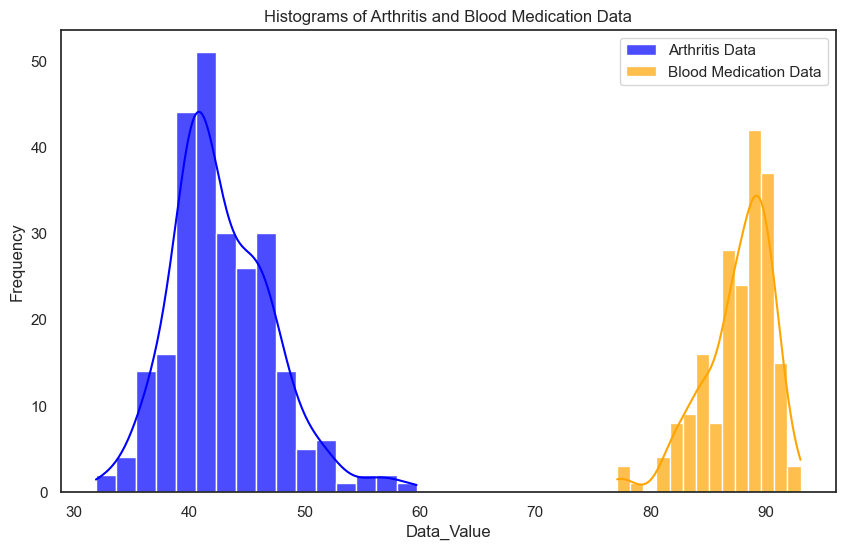

In [55]:
plt.figure(figsize=(10, 6))

sns.histplot(arthritis_data["Data_Value"],kde=True ,label="Arthritis Data", color="blue", alpha=0.7)
sns.histplot(blood_medication_data["Data_Value"], kde=True, label="Blood Medication Data", color="orange", alpha=0.7)
plt.legend()

# plt.xlabel("Data Value in %")
plt.ylabel("Frequency")
plt.title("Histograms of Arthritis and Blood Medication Data")

plt.show()

To see if there are any outliers, the visualization of a bloxplot is the best choice. As you can see in the following plot, we have no outliers in the dataset.

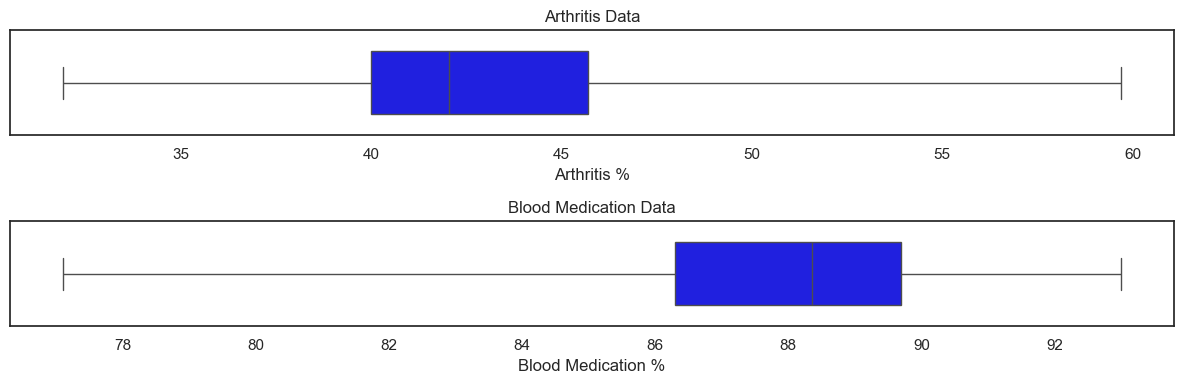

In [56]:
plt.figure(figsize=(12, 4))

plt.subplot(2, 1, 1)
sns.boxplot(
    data=arthritis_data, x="Data_Value",
    whis=[0, 100], width=.6, color="blue"
)
plt.title('Arthritis Data')
plt.xlabel('Arthritis %')

plt.subplot(2, 1, 2)
sns.boxplot(
    data=blood_medication_data, x="Data_Value",
    whis=[0, 100], width=.6, color="blue"
)
plt.title('Blood Medication Data')
plt.xlabel('Blood Medication %')

plt.tight_layout()
plt.show()

To work with clean data, all values in arthritis & blood_medication dataframe which have `NAN` values will be dropped. To display the result of the data with its corresponending regression line, a regplot is implemented.

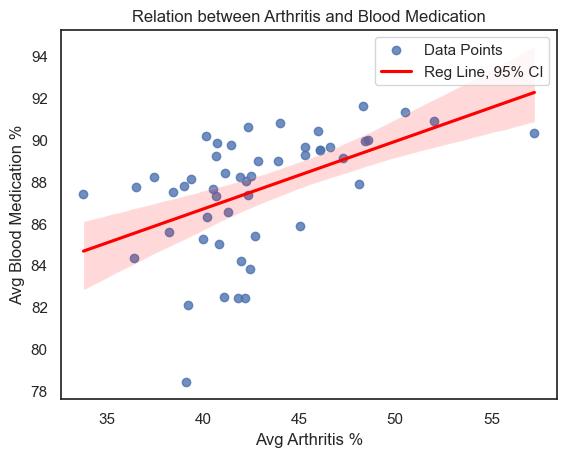

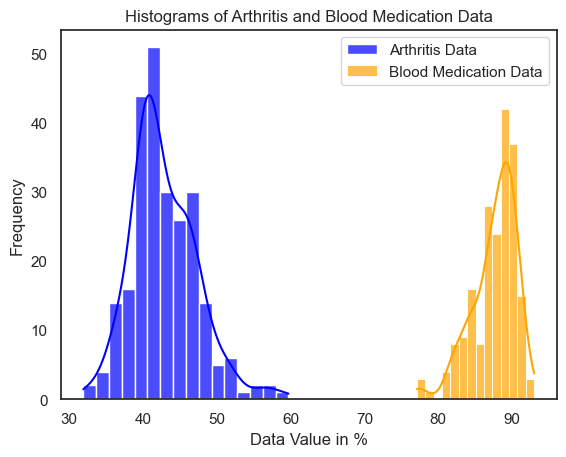

In [57]:
# Drop NAN values in Data_Value
arthritis_data = arthritis_data.dropna(subset=['Data_Value'])
blood_medication_data = blood_medication_data.dropna(subset=['Data_Value'])

# groupby Location and get the mean of Data_Value
avg_arthritis = arthritis_data.groupby('LocationAbbr')['Data_Value'].mean()
avg_blood_medication = blood_medication_data.groupby('LocationAbbr')['Data_Value'].mean()

df_avg = pd.DataFrame({'Average Arthritis': avg_arthritis, 'Average Blood Medication': avg_blood_medication})

# regression plot with 95% confidence interval
sns.regplot(data=df_avg, x='Average Arthritis', y='Average Blood Medication' ,ci=95, fit_reg=True, line_kws={'color':'red'}, truncate=True)
plt.xlabel('Avg Arthritis %')
plt.ylabel('Avg Blood Medication %')
plt.title('Relation between Arthritis and Blood Medication')
plt.legend(['Data Points', "Reg Line, 95% CI"])
plt.show()

sns.histplot(arthritis_data["Data_Value"],kde=True ,label="Arthritis Data", color="blue", alpha=0.7)
sns.histplot(blood_medication_data["Data_Value"], kde=True, label="Blood Medication Data", color="orange", alpha=0.7)
plt.legend()

plt.xlabel("Data Value in %")
plt.ylabel("Frequency")
plt.title("Histograms of Arthritis and Blood Medication Data")

plt.show()


In [58]:
correlation_coefficient, p_value = stats.pearsonr(avg_arthritis, avg_blood_medication)
correlation_coefficient, p_value

(0.4919916702597069, 0.0002847191829754953)

In the first step, the neccesary states-data need to be filtered. In case of this hypothesis, we need top extract two dataframes & and only take values of the Stratification "Overall", which face the data all races, ages and gender. On the one hand we have the arthritis data, and on the other the blood pressure medication. Both variables which needs to be observed (`Data_Value`) are in percentage. To get a first impression of the data, a 5-point analysis is made.

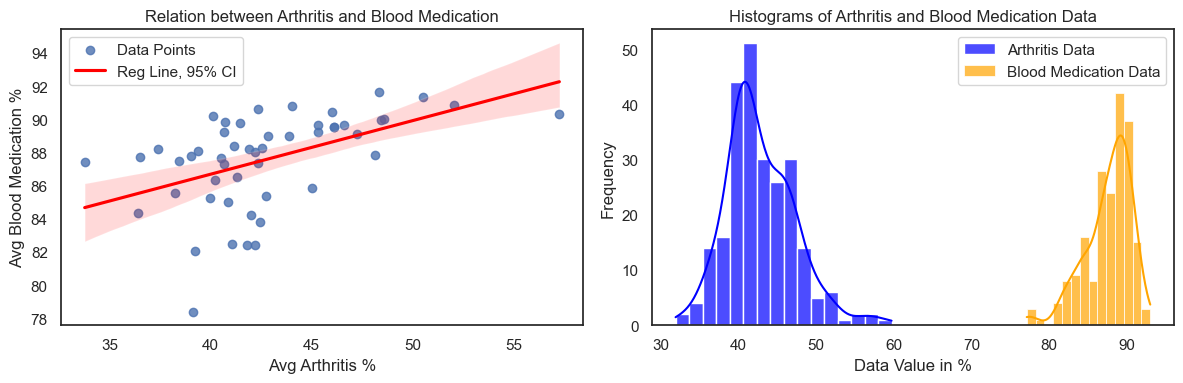

In [59]:
#For the report

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.regplot(data=df_avg, x='Average Arthritis', y='Average Blood Medication', ci=95, fit_reg=True, line_kws={'color':'red'}, truncate=True, ax=axs[0])
axs[0].set_xlabel('Avg Arthritis %')
axs[0].set_ylabel('Avg Blood Medication %')
axs[0].set_title('Relation between Arthritis and Blood Medication')
axs[0].legend(['Data Points', "Reg Line, 95% CI"])

sns.histplot(arthritis_data["Data_Value"], kde=True, label="Arthritis Data", color="blue", alpha=0.7, ax=axs[1])
sns.histplot(blood_medication_data["Data_Value"], kde=True, label="Blood Medication Data", color="orange", alpha=0.7, ax=axs[1])
axs[1].legend()
axs[1].set_xlabel("Data Value in %")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Histograms of Arthritis and Blood Medication Data")

plt.tight_layout()
plt.show()

### E3-H5: "States with higher rates of frequent mental distress tend to have higher rates of binge drinking."
Author: Martin Siska

Source: https://gothamist.com/news/1-in-6-new-yorkers-report-drinking-alcohol-excessively-ny-health-officials-say

This hypothesis examines that frequent mental distress is directly linked to increased instances of binge drinking within the last 30 days. 
Focused on individuals experiencing regular episodes of stress, anxiety, or depression, the research aims to investigate whether these mental health challenges correlate 
with a higher likelihood of engaging in binge drinking as a coping mechanism. This concise exploration seeks to understand the behavioral and psychological connections between mental distress and alcohol consumption patterns.






In [67]:
df_cleaned_h5 = df_states[
  (df_states['Data_Value_Unit'] == '%') & 
  (df_states['StratificationID1'] == 'AGE_OVERALL') &
  (df_states['StratificationCategoryID2'] == 'OVERALL')
  ] 

# Filtering data for 'Frequent Mental Distress' and 'Binge Drinking'
mental_distress_data = df_cleaned_h5[df_cleaned_h5['Topic'].str.contains('Frequent Mental Distress', case=False)]
binge_drinking_data = df_cleaned_h5[df_cleaned_h5['Topic'].str.contains('Binge Drinking within Past 30 Days', case=False)]

# Dropping rows with missing 'Data_Value' in both datasets to ensure completeness
mental_distress_data = mental_distress_data.dropna(subset=['Data_Value'])
binge_drinking_data = binge_drinking_data.dropna(subset=['Data_Value'])

# Grouping the data by 'LocationAbbr'
avg_mental = mental_distress_data.groupby('LocationAbbr')['Data_Value'].mean()
avg_drinking = binge_drinking_data.groupby('LocationAbbr')['Data_Value'].mean()

# Creating a new dataframe with the average values for mental distress and binge drinking
df_avg = pd.DataFrame({'Average Mental Distress': avg_mental, 'Average Binge Drinking': avg_drinking})

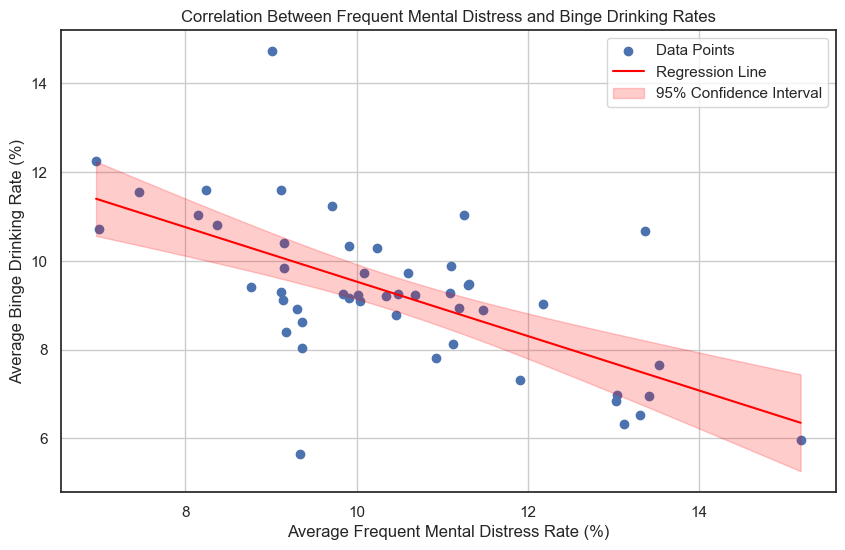

In [68]:
# Extract the top 5 states for 'Average Mental Distress'
top_5_mental_distress = df_avg.nlargest(5, 'Average Mental Distress')

# Extract the top 5 states for 'Average Binge Drinking'
top_5_binge_drinking = df_avg.nlargest(5, 'Average Binge Drinking')

slope, intercept, r_value, p_value, std_err = stats.linregress(avg_mental, avg_drinking)

# Create arrays for the regression line
x = np.array(avg_mental)
y = np.array(avg_drinking)
x_reg = np.linspace(x.min(), x.max(),100)
y_reg = slope * x_reg + intercept

# Calculate the prediction interval
pred_error = y - (slope * x + intercept)
degrees_of_freedom = len(x) - 2
residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
t_stat = stats.t.ppf(1-0.025, df=degrees_of_freedom)  # 2-tailed t-statistic for 95% CI
conf_interval = t_stat * residual_std_error * np.sqrt(1/len(x) + (x_reg - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Creating scatter plot with regression line and confidence interval of 95%
plt.figure(figsize=(10, 6))

plt.scatter(x, y, label='Data Points')
plt.plot(x_reg, y_reg, color='red', label='Regression Line')

# Filling the confidence interval
plt.fill_between(x_reg, y_reg - conf_interval, y_reg + conf_interval, color='red', alpha=0.2, label='95% Confidence Interval')

# Adding labels and title
plt.title('Correlation Between Frequent Mental Distress and Binge Drinking Rates')
plt.xlabel('Average Frequent Mental Distress Rate (%)')
plt.ylabel('Average Binge Drinking Rate (%)')
plt.legend()
plt.grid(True) 
plt.show()

In [69]:
correlation_coefficient, p_value = stats.pearsonr(avg_mental, avg_drinking)

print('Correlation value: ',correlation_coefficient)
print('P-value: ', p_value)

Correlation value:  -0.6382826596867076
P-value:  6.143059808399372e-07


The Pearson correlation coefficient between average rates of 'Frequent Mental Distress' and 'Binge Drinking' is approximately -0.64,
and the p-value is approximately 0.00000061. This p-value is much lower than the significance level of 0.025 that is alpha for 95% confidence interval,
indicating that the negative correlation between the two variables is statistically significant. 

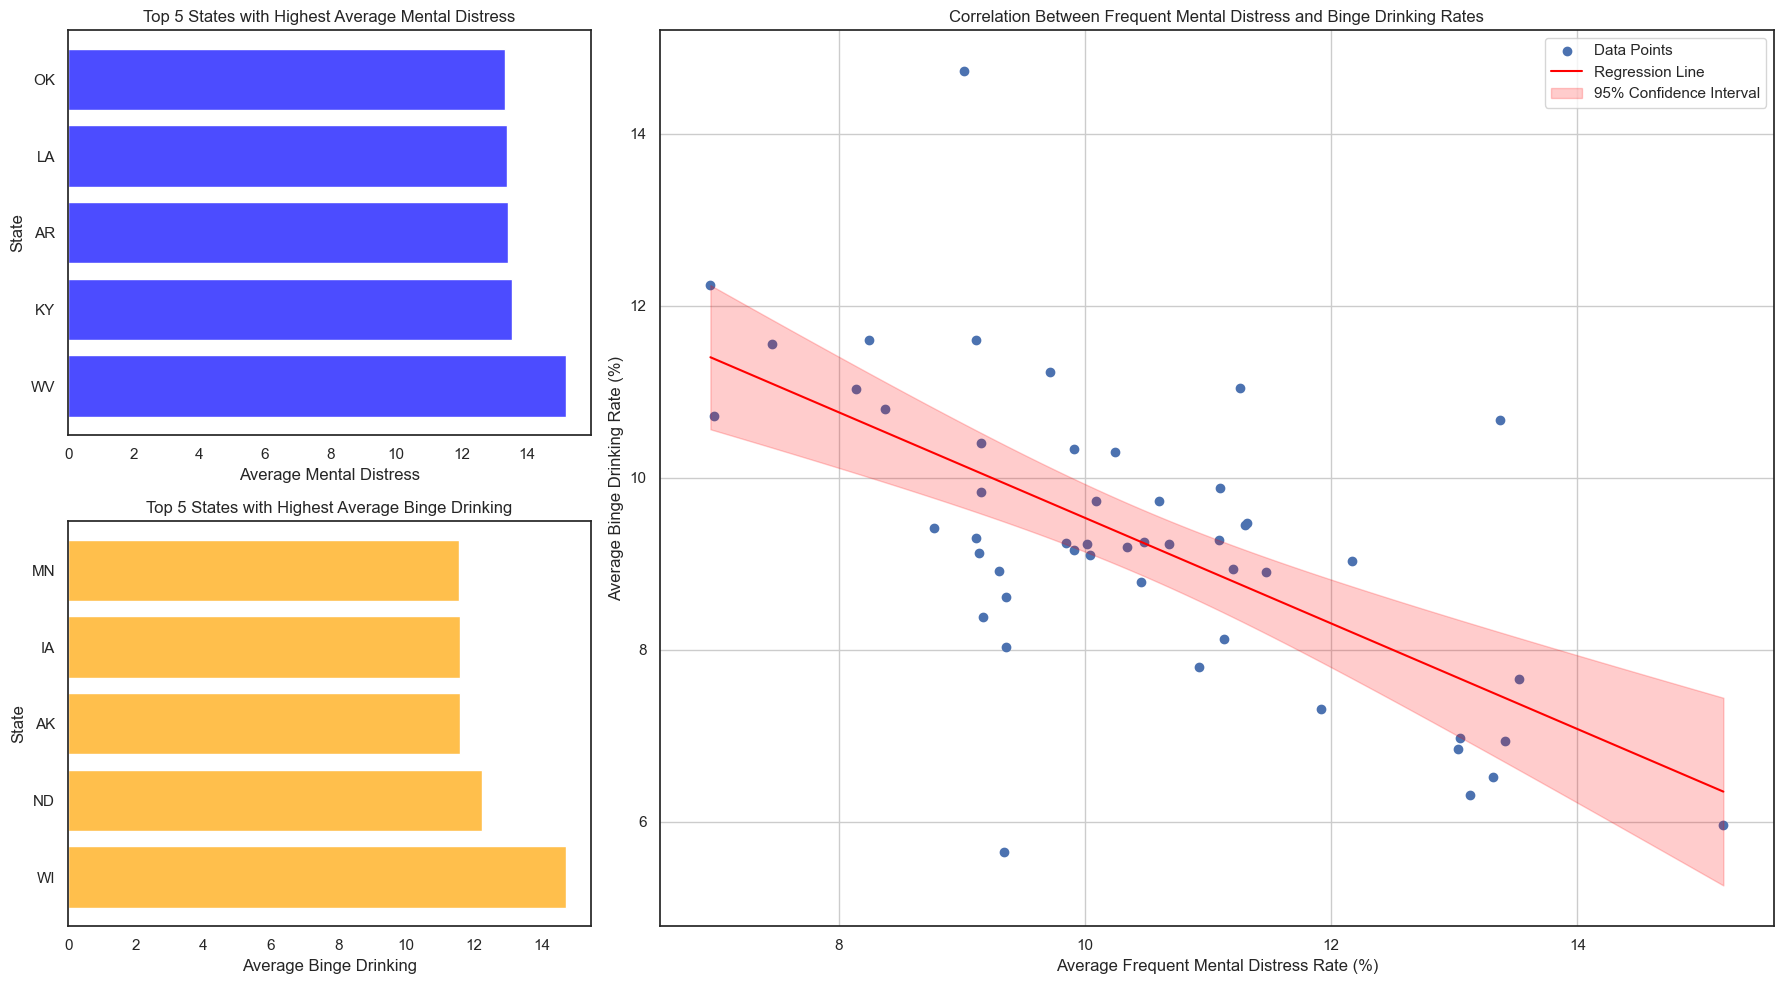

In [70]:
fig = plt.figure(figsize=(18, 10))

# Defining the axes
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=1, colspan=1)  # Top 5 States
ax2 = plt.subplot2grid((2, 3), (1, 0), rowspan=1, colspan=1)  # Bottom 5 States
ax3 = plt.subplot2grid((2, 3), (0, 1), rowspan=2, colspan=2)  # Scatter Plot

# Plotting the top 5 states with horizontal bars
ax1.barh(top_5_mental_distress.index, top_5_mental_distress['Average Mental Distress'], color='#4C4CFF')
ax1.set_title('Top 5 States with Highest Average Mental Distress')
ax1.set_xlabel('Average Mental Distress')
ax1.set_ylabel('State')

# Plotting the bottom 5 states with horizontal bars
ax2.barh(top_5_binge_drinking.index, top_5_binge_drinking['Average Binge Drinking'], color='#FFBF4C')
ax2.set_title('Top 5 States with Highest Average Binge Drinking')
ax2.set_xlabel('Average Binge Drinking')
ax2.set_ylabel('State')

# Scatter plot with regression line and confidence interval
ax3.scatter(x, y, label='Data Points')
ax3.plot(x_reg, y_reg, color='red', label='Regression Line')
ax3.fill_between(x_reg, y_reg - conf_interval, y_reg + conf_interval, color='red', alpha=0.2, label='95% Confidence Interval')
ax3.set_title('Correlation Between Frequent Mental Distress and Binge Drinking Rates')
ax3.set_xlabel('Average Frequent Mental Distress Rate (%)')
ax3.set_ylabel('Average Binge Drinking Rate (%)')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

The plot above displays three data visualizations: two bar charts showing the top five states with the highest rates of average mental distress and binge drinking, and a scatter plot depicting a negative correlation between mental distress and binge drinking rates across various states. The scatter plot includes a red regression line with a confidence interval, suggesting a trend where states with higher mental distress tend to have lower binge drinking rates. 

Based on this visual as well as the calculated pearson correlation can be concluded, that the hypothesis H0 'States with higher rates of frequent mental distress tend to have higher rates of binge drinking' has proven to be not valid. Based on the data
provided, conclusion can be made that states with higher rates of mental distress are more likely to binge drink compared to states with lower mental distress, where average bindge drinking in the last 30 days shows higher values.